## Influence of AI as perceived by the Stackoverflow users during the last years

I want to analyze how AI has shaped the Stackoverflow surveys during the last years and how the users perceived it.

### Loading libraries and data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Patch
import seaborn as sns
import os
import glob
import re
import math
from collections import defaultdict, Counter
from typing import Optional, Dict, List, Tuple, Literal
%matplotlib inline

pd.set_option('display.max_colwidth', None)

In [2]:
# -------------------------------------------------------------------
# Load the data of several stackoverflow user surveys into data frames
# -------------------------------------------------------------------
def load_stackoverflow_data(folder_path, load_schema=False):
    """
    Load Stack Overflow survey or schema CSV files from a folder into a dictionary of DataFrames.
    
    Parameters:
        folder_path (str): Path to the folder containing CSV files.
        load_schema (bool): If True, load schema files (filenames containing 'schema').
                            If False, load survey response files.
    
    Returns:
        dict: { 'survey_<year>': DataFrame }
    """
    # Determine filter based on schema flag
    if load_schema:
        csv_files = [f for f in glob.glob(os.path.join(folder_path, "*.csv")) if "schema" in os.path.basename(f).lower()]
    else:
        csv_files = [f for f in glob.glob(os.path.join(folder_path, "*.csv")) if "schema" not in os.path.basename(f).lower()]

    data_dict = {}

    for file in csv_files:
        filename = os.path.basename(file)
        
        # Extract year from filename
        match = re.search(r"(20)\d{2}", filename)
        year = int(match.group()) if match else None
        
        # Read CSV with encoding fallback
        try:
            df = pd.read_csv(file, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file, encoding="latin1")
        
        # Add Year column
        df["Year"] = year
        
        # Create dictionary key
        key_name = f"survey_{year}" if year else "survey_unknown"
        data_dict[key_name] = df

    return data_dict


In [3]:
schema_dfs = load_stackoverflow_data(folder_path="data", load_schema=True)
survey_dfs = load_stackoverflow_data(folder_path="data", load_schema=False)

C:\Users\UUJI17D\AppData\Local\Temp\1\ipykernel_18388\3995078611.py:33: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding="utf-8")


In [4]:
survey_dfs.keys()

dict_keys(['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025'])

In [5]:
schema_dfs.keys()

dict_keys(['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025'])

### Definition of helper functions for data assessment

In [6]:
# -------------------------------------------------------------------
# Find common columns across a set of dataframes
# -------------------------------------------------------------------
def find_common_columns(df_set):
    """
    Find columns that appear in at least two DataFrames and show which surveys they belong to.
    Sorted by frequency (descending).

    Args:
        df_set (dict): Dictionary of DataFrames {survey_name: DataFrame}

    Returns:
        list of tuples: [(column_name, count, [surveys]), ...] sorted by count desc
    """
    # Map each column to the surveys it appears in
    column_map = defaultdict(list)
    for survey_name, df in df_set.items():
        for col in df.columns:
            column_map[col].append(survey_name)

    # Keep only columns that appear in at least two surveys
    common_columns = {col: surveys for col, surveys in column_map.items() if len(surveys) >= 2}

    # Sort by frequency
    common_sorted = sorted(
        [(col, len(surveys), surveys) for col, surveys in common_columns.items()],
        key=lambda x: x[1],
        reverse=True
    )

    # Print results
    print("Columns common to at least two surveys (sorted by frequency):")
    for col, count, surveys in common_sorted:
        print(f"{col} ({count} surveys): {surveys}")

    return common_sorted

In [7]:
# -------------------------------------------------------------------
# Find columns that are unique to a single survey
# -------------------------------------------------------------------
def find_unique_columns(df_set):
    """
    Find columns that are unique to a single survey, list them by survey, and provide a summary count.

    Args:
        df_set (dict): Dictionary of DataFrames {survey_name: DataFrame}

    Returns:
        dict: {survey: [unique_columns]}
    """
    
    # Map each column to the surveys it appears in
    column_map = defaultdict(list)
    for survey_name, df in df_set.items():
        for col in df.columns:
            column_map[col].append(survey_name)

    # Filter unique columns
    unique_columns = {col: surveys for col, surveys in column_map.items() if len(surveys) == 1}

    # Organize by survey
    survey_unique_map = defaultdict(list)
    for col, surveys in unique_columns.items():
        survey_unique_map[surveys[0]].append(col)

    # Sort surveys alphabetically and columns inside each survey
    survey_unique_map = {survey: sorted(cols) for survey, cols in sorted(survey_unique_map.items())}

    # Print results
    print("Unique columns per survey:")
    for survey, cols in survey_unique_map.items():
        print(f"{survey} ({len(cols)} unique columns): {cols}")

    return survey_unique_map

In [8]:
# -------------------------------------------------------------------
# Find questions across all surveys by keyword
# -------------------------------------------------------------------
def find_questions_by_keyword(schema_dfs, keyword,
                               col_name_cols=("Column", "qname"),
                               question_cols=("question", "QuestionText", "Question"),
                               case=True, verbose=True):
    """
    Find all questions containing a given keyword AND a question mark across multiple schema DataFrames.

    Parameters:
        schema_dfs (dict): {survey_name: DataFrame}
        keyword (str): keyword to search for
        col_name_cols (tuple): possible column name fields
        question_cols (tuple): possible question text fields
        case (bool): case-sensitive search (default False)
        verbose (bool): if True, prints grouped results

    Returns:
        DataFrame: ['survey', 'column_name', 'question']
    """
    
    rows = []
    pattern = f"(?=.*{re.escape(keyword)})(?=.*[?？])"  # keyword + question mark

    for survey_name, schema in schema_dfs.items():
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not col_name_col or not q_col:
            continue

        mask = schema[q_col].astype(str).str.contains(pattern, case=case, na=False, regex=True)
        matches = schema.loc[mask, [col_name_col, q_col]].copy()
        if not matches.empty:
            matches["survey"] = survey_name
            matches.rename(columns={col_name_col: "column_name", q_col: "question"}, inplace=True)
            rows.append(matches)

    if not rows:
        if verbose:
            print(f"No matches found for keyword '{keyword}' with a question mark.")
        return pd.DataFrame(columns=["survey", "column_name", "question"])

    df = pd.concat(rows, ignore_index=True)

    if verbose:
        print(f"Found {len(df)} matches for keyword '{keyword}':")
        for survey in df["survey"].unique():
            print(f"\n--- {survey} ---")
            subset = df[df["survey"] == survey]
            for _, row in subset.iterrows():
                print(f"{row['column_name']}: {row['question']}")

    return df


In [9]:
# -------------------------------------------------------------------
# Find either duplicated questions or column names across all surveys
# -------------------------------------------------------------------
def find_duplicates_across_surveys(df, check_on="question", duplicate_min=2, only_duplicates=True, verbose=True):
    """
    Find duplicates across surveys based on question text OR column_name.

    Parameters:
        df (DataFrame): Output from find_questions_by_keyword or similar
        check_on (str): 'question' or 'column_name' (field to check duplicates on)
        duplicate_min (int): Minimum number of surveys for a duplicate (default 2)
        only_duplicates (bool): If True, return only rows that meet the duplicate_min threshold
        verbose (bool): if True, prints grouped results

    Returns:
        DataFrame: ['survey', 'column_name', 'question', 'survey_count', 'duplicate_flag']
    """
    import pandas as pd
    import re
    import unicodedata

    if df.empty:
        if verbose:
            print("No data to check for duplicates.")
        return pd.DataFrame(columns=["survey", "column_name", "question", "survey_count", "duplicate_flag"])

    # Normalization for grouping
    def normalize(text):
        text = unicodedata.normalize("NFKC", str(text))
        text = text.replace("\u00A0", " ").replace("\u202F", " ")
        text = re.sub(r"[\u200B-\u200D\u2060\uFEFF]", "", text)
        text = text.replace("*", "").replace("＊", "")
        text = re.sub(r"\s+", " ", text.lower()).strip()
        return text

    if check_on not in ["question", "column_name"]:
        raise ValueError("check_on must be 'question' or 'column_name'")

    df = df.copy()
    df["normalized"] = df[check_on].apply(normalize)
    df = df[df["normalized"].ne("")]

    # Count surveys per normalized value
    survey_counts = df.groupby("normalized")["survey"].nunique()
    df["survey_count"] = df["normalized"].map(survey_counts)
    df["duplicate_flag"] = df["survey_count"] >= duplicate_min

    # Filter if only duplicates requested
    if only_duplicates:
        df = df[df["duplicate_flag"]]

    df = df.drop(columns="normalized").sort_values(
        by=["duplicate_flag", "survey_count", "survey"], ascending=[False, False, True]
    ).reset_index(drop=True)

    if verbose and not df.empty:
        print(f"Duplicates based on {check_on} (min surveys = {duplicate_min}):")
        for survey in df["survey"].unique():
            print(f"\n--- {survey} ---")
            subset = df[df["survey"] == survey]
            for _, row in subset.iterrows():
                marker = f" (DUPLICATE, {row['survey_count']})" if row['survey_count'] >= duplicate_min else ""
                print(f"{row['column_name']}: {row['question']}{marker}")
    elif verbose:
        print("No duplicates found.")

    return df


In [10]:
# -------------------------------------------------------------------
# Retrieve the question for a given column name across all surveys
# -------------------------------------------------------------------
def get_question_description(column_name, schema_dfs,
                    col_name_cols=("Column", "qname"),
                    question_cols=("question", "QuestionText", "Question"),
                    return_all=True):
    """
    Retrieve the description of a column from multiple schema DataFrames.

    Parameters:
        column_name (str): The name of the column you want to look up.
        schema_dfs (dict): {survey_name: DataFrame} of schema tables.
        col_name_cols (tuple): Possible column names that identify the column name in the schema.
        question_cols (tuple): Possible column names that contain the question text.
        return_all (bool): If True, return all matches as a dict {survey: description}. 
                           If False, return the first match.

    Returns:
        str or dict: The description of the column (first match) or a dict of all matches.
    """
    
    results = {}

    for survey_name, schema in schema_dfs.items():
        # Find which column in schema holds the column names
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        if not col_name_col:
            continue

        # Find which column in schema holds the question text
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not q_col:
            continue

        # Filter for the requested column_name
        match = schema.loc[schema[col_name_col] == column_name, q_col]

        if not match.empty:
            results[survey_name] = match.iloc[0]
            if not return_all:
                return match.iloc[0]

    return results if results else None


In [11]:
# -------------------------------------------------------------------
# Retrieve the column name for a given question across all surveys
# -------------------------------------------------------------------
def get_column_name(question_text, schema_dfs,
                    col_name_cols=("Column", "qname"),
                    question_cols=("question", "QuestionText", "Question"),
                    case=False, return_all=True):
    """
    Find column name(s) for a given question text from multiple schema DataFrames.
    Handles case-insensitive and partial matches, and escapes regex characters.

    Parameters:
        question_text (str): The question text (or part of it) to search for.
        schema_dfs (dict): {survey_name: DataFrame} of schema tables.
        col_name_cols (tuple): Possible column name fields in schema.
        question_cols (tuple): Possible question text fields in schema.
        case (bool): Case-sensitive search (default False).
        return_all (bool): If True, return all matches as {survey: [columns]}.
                           If False, return the first match found.

    Returns:
        dict or str or None
    """
    results = {}

    # Normalize query: collapse whitespace and lowercase if case=False
    query = " ".join(question_text.split())
    if not case:
        query = query.lower()

    for survey_name, schema in schema_dfs.items():
        # Detect relevant columns
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not col_name_col or not q_col:
            continue

        # Normalize schema question text
        q_series = schema[q_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        if not case:
            q_series = q_series.str.lower()

        # Escape regex special chars in query for literal match
        pattern = re.escape(query)

        mask = q_series.str.contains(pattern, na=False)
        matches = schema.loc[mask, col_name_col]

        if not matches.empty:
            results[survey_name] = matches.tolist()
            if not return_all:
                return matches.iloc[0]

    return results if results else None


In [128]:
# -------------------------------------------------------------------
# Calculate the value count of a given column across all surveys
# -------------------------------------------------------------------
def value_counts_all_surveys(survey_dfs, column_name, normalize=False, dropna=True, verbose=False):
    """
    Compute value counts for a given column across all surveys, with optional verbose output.

    Parameters:
        survey_dfs (dict): {survey_name: DataFrame}
        column_name (str): Column to compute value counts for
        normalize (bool): If True, return relative frequencies (like pandas normalize)
        dropna (bool): If True, exclude NaN values
        verbose (bool): If True, print detailed info for each survey

    Returns:
        dict: {survey_name: Series of value counts}
    """
    results = {}

    for survey_name, df in survey_dfs.items():
        if column_name in df.columns:
            counts = df[column_name].value_counts(normalize=normalize, dropna=dropna)
            results[survey_name] = counts

            if verbose:
                print(f"\n--- Survey: {survey_name} ---")
                print(f"Column analyzed: {column_name}")
                print(f"Total rows: {len(df)}")
                print(f"Unique values: {df[column_name].nunique(dropna=dropna)}")
                print(f"NaN values: {df[column_name].isna().sum()}")
                print("Value counts:")
                print(counts.to_string())  # Full output without truncation
        else:
            results[survey_name] = None
            if verbose:
                print(f"\n--- Survey: {survey_name} ---")
                print(f"Column '{column_name}' not found in this survey.")

    return results

In [138]:
# -------------------------------------------------------------------
# Replace missing values in the survey data with "no answer"
# -------------------------------------------------------------------
def replace_missing_all_columns(
    survey_dfs: Dict[str, pd.DataFrame],
    na_label: str = "No answer",
    treat_blank_as_na: bool = True,
    as_category: bool = True,
    inplace: bool = False
) -> Dict[str, pd.DataFrame]:
    """
    Replace NaN (and optionally blank strings) in ALL columns of each survey DataFrame.

    Parameters
    ----------
    survey_dfs : dict[str, pd.DataFrame]
        Mapping of survey name -> DataFrame.
    na_label : str, default "No answer"
        Label to use for missing values.
    treat_blank_as_na : bool, default True
        If True, empty/whitespace-only strings are treated as NaN before replacement.
    as_category : bool, default True
        If True, convert all object/string columns to 'category' after replacement.
    inplace : bool, default False
        If True, modify DataFrames in `survey_dfs` directly and return the same dict.
        If False, return a new dict with copies.

    Returns
    -------
    dict[str, pd.DataFrame]
        Dict of processed DataFrames (same object if inplace=True).
    """
    out = survey_dfs if inplace else {}

    for name, df in survey_dfs.items():
        target = df if inplace else df.copy()

        # Optionally treat blanks as NaN
        if treat_blank_as_na:
            target = target.replace(r"^\s*$", pd.NA, regex=True)

        # Replace all NaNs with na_label
        target = target.fillna(na_label)

        # Convert object columns to category if requested
        if as_category:
            for col in target.columns:
                if target[col].dtype == object or pd.api.types.is_string_dtype(target[col]):
                    target[col] = target[col].astype("category")

        if not inplace:
            out[name] = target

    return out


### Data assessment and wrangling

First, let's make a copy of the original dataframe in case we need to make changes for the analysis.

In [13]:
schema_dfs_original = schema_dfs.copy()

In [14]:
survey_common_cols = find_common_columns(survey_dfs)

Columns common to at least two surveys (sorted by frequency):
Country (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Year (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Employment (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
DevType (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Age (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Currency (7 surveys): ['survey_2017', 'survey_2018', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
MainBranch (7 surveys): ['survey_2019', 'survey_2020', 'survey_2021', 'sur

In [15]:
survey_unique_cols = find_unique_columns(survey_dfs)

Unique columns per survey:
survey_2017 (137 unique columns): ['AnnoyingUI', 'AssessJobCommute', 'AssessJobCompensation', 'AssessJobDept', 'AssessJobDiversity', 'AssessJobExp', 'AssessJobFinances', 'AssessJobIndustry', 'AssessJobLeaders', 'AssessJobOffice', 'AssessJobProduct', 'AssessJobProfDevel', 'AssessJobProjects', 'AssessJobRemote', 'AssessJobRole', 'AssessJobTech', 'AuditoryEnvironment', 'BoringDetails', 'BuildingThings', 'ChallengeMyself', 'ChangeWorld', 'ClickyKeys', 'CollaborateRemote', 'CompanyType', 'CompetePeers', 'CousinEducation', 'DeveloperType', 'DifficultCommunication', 'DiversityImportant', 'EducationImportant', 'EmploymentStatus', 'EnjoyDebugging', 'EquipmentSatisfiedCPU', 'EquipmentSatisfiedMonitors', 'EquipmentSatisfiedRAM', 'EquipmentSatisfiedRW', 'EquipmentSatisfiedStorage', 'ExCoder10Years', 'ExCoderActive', 'ExCoderBalance', 'ExCoderBelonged', 'ExCoderNotForMe', 'ExCoderReturn', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExpectedSalary', 'FriendsDevelopers', 'HaveW

In [16]:
schema_common_cols = find_common_columns(schema_dfs)

Columns common to at least two surveys (sorted by frequency):
Year (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
qid (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
qname (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
question (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
type (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Column (4 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020']
force_resp (4 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024']
selector (4 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024']
QuestionText (3 surveys): ['survey_2018', 'survey_2019', 'survey_2020']


In [17]:
schema_unique_cols = find_unique_columns(schema_dfs)

Unique columns per survey:
survey_2017 (1 unique columns): ['Question']
survey_2025 (2 unique columns): ['sq_id', 'sub']


In [18]:
df_matches = find_questions_by_keyword(schema_dfs, "AI")

Found 55 matches for keyword 'AI':

--- survey_2018 ---
AIDangerous: What do you think is the most dangerous aspect of increasingly advanced AI technology?
AIInteresting: What do you think is the most exciting aspect of increasingly advanced AI technology?
AIResponsible: Whose responsibility is it, <u>primarily</u>, to consider the ramifications of increasingly advanced AI technology?

--- survey_2019 ---
PurchaseHow: How does your company make decisions about purchasing new technology (cloud, AI, IoT, databases)?

--- survey_2023 ---
AISearch: Which <b>AI-powered search tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply.
AIDev: Which <b>AI-powered developer tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply
SOAI: Artificial Intelligence (AI) tools have gained prominence recently across industries. The following question asks for yo

In [192]:
df_matches.head()

,column_name,question,survey
0,AIDangerous,What do you think is the most dangerous aspect of increasingly advanced AI technology?,survey_2018
1,AIInteresting,What do you think is the most exciting aspect of increasingly advanced AI technology?,survey_2018
2,AIResponsible,"Whose responsibility is it, <u>primarily</u>, to consider the ramifications of increasingly advanced AI technology?",survey_2018
3,PurchaseHow,"How does your company make decisions about purchasing new technology (cloud, AI, IoT, databases)?",survey_2019
4,AISearch,"Which <b>AI-powered search tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply.",survey_2023


In [19]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question")

Duplicates based on question (min surveys = 2):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIBen: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply. (DUPLICATE, 2)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 2)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do

In [20]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question", duplicate_min=3)

Duplicates based on question (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIBen: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2025 ---
AISelect: Do you currently use AI tools in your development process? (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI

In [21]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="column_name", duplicate_min=3)

Duplicates based on column_name (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply. (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which p

In [22]:
df_matches["survey"].value_counts()

survey
survey_2025    31
survey_2024    11
survey_2023     9
survey_2018     3
survey_2019     1
Name: count, dtype: int64

In [23]:
get_question_description("AIBen", schema_dfs)

{'survey_2023': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2024': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.'}

In [24]:
get_question_description("AIAcc", schema_dfs)

{'survey_2023': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.',
 'survey_2024': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2025': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?'}

In [25]:
schema_dfs["survey_2023"][schema_dfs["survey_2023"]["qname"]=="AIBen"]

,qid,qname,question,force_resp,type,selector,Year
49,QID316,AIBen,How much do you trust the accuracy of the output from AI tools as part of your development workflow?,False,MC,SAVR,2023


In [26]:
survey_dfs["survey_2023"]["AIBen"].head()

0                  NaN
1    Somewhat distrust
2                  NaN
3                  NaN
4       Somewhat trust
Name: AIBen, dtype: object

In [27]:
get_column_name("For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.", schema_dfs)

{'survey_2023': ['AIAcc'], 'survey_2024': ['AIBen']}

In [28]:
get_column_name("How much do you trust the accuracy of the output from AI tools as part of your development workflow?", schema_dfs)

{'survey_2023': ['AIBen'], 'survey_2024': ['AIAcc'], 'survey_2025': ['AIAcc']}

For the Survey of 2023, the questions regarding AI benefits and accuracy have been marked with the wrong name, therefore we need to replace it both in the survey and in the schema data.

In [29]:
schema_dfs["survey_2023"]["qname"] = schema_dfs["survey_2023"]["qname"].replace({"AIBen": "AIAcc", "AIAcc": "AIBen"})
survey_dfs["survey_2023"].rename(columns={"AIBen": "AIAcc", "AIAcc": "AIBen"}, inplace=True)

In [30]:
get_question_description("AIBen", schema_dfs)

{'survey_2023': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.',
 'survey_2024': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.'}

In [31]:
get_question_description("AIAcc", schema_dfs)

{'survey_2023': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2024': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2025': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?'}

In [32]:
df_matches = find_questions_by_keyword(schema_dfs, "AI", verbose=False)

In [33]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question", duplicate_min=3)

Duplicates based on question (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2025 ---
AISelect: Do you currently use AI tools in your development process? (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI

In [34]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="column_name", duplicate_min=3)

Duplicates based on column_name (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently usi

In [129]:
counts_AIAcc = value_counts_all_surveys(survey_dfs, 'AIAcc', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2018 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2019 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2020 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2021 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2022 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AIAcc
Total rows: 89184
Unique values: 5
NaN values: 27788
Value counts:
AIAcc
Somewhat trust                24128
Neither trust nor distrust    18837
Somewhat distrust             13330
Highly distrust                3350
Highly trust                   1751

--- Survey: survey_2024 ---
Column analyzed: AIAcc
Total rows: 65437
Unique values: 5
NaN values: 28135
Value counts:
AIAcc
Somewhat trust                15039
Neither trust nor distrust     9920
Somewhat distrust              8395
Highly distrust                2932
Highly

In [130]:
counts_AISelect = value_counts_all_surveys(survey_dfs, 'AISelect', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2018 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2019 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2020 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2021 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2022 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AISelect
Total rows: 89184
Unique values: 3
NaN values: 1211
Value counts:
AISelect
Yes                        39042
No, and I don't plan to    26221
No, but I plan to soon     22710

--- Survey: survey_2024 ---
Column analyzed: AISelect
Total rows: 65437
Unique values: 3
NaN values: 4530
Value counts:
AISelect
Yes                        37662
No, and I don't plan to    14837
No, but I plan to soon      8408

--- Survey: survey_2025 ---
Column analyzed: AISelect
Total rows: 49123
Unique values: 5
NaN values: 15

In [131]:
counts_AISent = value_counts_all_surveys(survey_dfs, 'AISent', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2018 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2019 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2020 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2021 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2022 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AISent
Total rows: 89184
Unique values: 6
NaN values: 27683
Value counts:
AISent
Favorable           29863
Very favorable      17050
Indifferent         10147
Unsure               2471
Unfavorable          1698
Very unfavorable      272

--- Survey: survey_2024 ---
Column analyzed: AISent
Total rows: 65437
Unique values: 6
NaN values: 19564
Value counts:
AISent
Favorable           22167
Very favorable      10848
Indifferent          8564
Unfavorable          2381
Unsure               1357
Very unfavorable      556

--- Sur

In [132]:
counts_AITool = value_counts_all_surveys(survey_dfs, 'AITool', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2018 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2019 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2020 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2021 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2022 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2023 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2024 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2025 ---
Column 'AITool' not found in this survey.


Let's address the NaNs in the surveys by replacing them with "no answer":

In [139]:
survey_dfs = replace_missing_all_columns(
    survey_dfs,
    na_label="No answer",
    treat_blank_as_na=True,
    as_category=True,
    inplace=False
)

In [140]:
counts_AISent = value_counts_all_surveys(survey_dfs, 'AISent', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2018 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2019 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2020 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2021 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2022 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AISent
Total rows: 89184
Unique values: 7
NaN values: 0
Value counts:
AISent
Favorable           29863
No answer           27683
Very favorable      17050
Indifferent         10147
Unsure               2471
Unfavorable          1698
Very unfavorable      272

--- Survey: survey_2024 ---
Column analyzed: AISent
Total rows: 65437
Unique values: 7
NaN values: 0
Value counts:
AISent
Favorable           22167
No answer           19564
Very favorable      10848
Indifferent          8564
Unfavorable          2381
Unsure          

Next, we want to investigate the column "AITool" which was not found in the survey data although it is a valid column name according to the schema data.

In [39]:
get_question_description("AITool", schema_dfs)

{'survey_2023': 'Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply.',
 'survey_2024': 'Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply.',
 'survey_2025': 'Which parts of your development workflow are you currently integrating into AI or using AI tools to accomplish or plan to use AI to accomplish over the next 3 - 5 years?  Please select one for each scenario.'}

In [40]:
tool_col_names = [col for col in survey_dfs["survey_2023"].columns if "AITool" in col]
survey_dfs["survey_2023"][tool_col_names].head(10)

,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using
0,NaN,NaN,NaN
1,Learning about a codebase;Writing code;Debugging and getting help,Writing code;Committing and reviewing code,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,Project planning;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates,Learning about a codebase;Writing code;Documenting code;Debugging and getting help,NaN
5,Learning about a codebase;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates,Writing code;Debugging and getting help,Project planning
6,NaN,Writing code;Debugging and getting help,Learning about a codebase;Project planning;Writing code;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates
7,Project planning;Writing code;Documenting code;Debugging and getting help;Testing code;Committing and reviewing code,Project planning;Writing code;Debugging and getting help,NaN
8,Learning about a codebase;Writing code;Documenting code;Deployment and monitoring,NaN,NaN
9,Learning about a codebase;Documenting code;Committing and reviewing code,Writing code;Debugging and getting help,Project planning;Testing code;Deployment and monitoring;Collaborating with teammates


In [41]:
[item for item in schema_dfs["survey_2023"]["qname"] if "AITool" in item]

['AITool']

In [42]:
schema_dfs["survey_2023"][schema_dfs["survey_2023"]["qname"]=="AITool"]

,qid,qname,question,force_resp,type,selector,Year
50,QID319,AITool,Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year? Please select all that apply.,False,Matrix,Likert,2023


In [43]:
tool_col_names = [col for col in survey_dfs["survey_2024"].columns if "AITool" in col]
survey_dfs["survey_2024"][tool_col_names].head(10)

,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,Learning about a codebase;Project planning;Writing code;Documenting code;Debugging and getting help;Deployment and monitoring;Search for answers;Generating content or synthetic data,Testing code;Committing and reviewing code;Predictive analytics,NaN
4,NaN,NaN,NaN
5,Writing code;Debugging and getting help,Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data,Learning about a codebase;Project planning
6,NaN,NaN,NaN
7,Writing code;Debugging and getting help;Search for answers,Project planning;Testing code,NaN
8,NaN,NaN,NaN
9,Search for answers,NaN,NaN


In [44]:
[item for item in schema_dfs["survey_2024"]["qname"] if "AITool" in item]

['AITool']

In [45]:
schema_dfs["survey_2024"][schema_dfs["survey_2024"]["qname"]=="AITool"]

,qid,qname,question,force_resp,type,selector,Year
44,QID319,AITool,Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year? Please select all that apply.,False,Matrix,Likert,2024


In [46]:
tool_col_names = [col for col in survey_dfs["survey_2025"].columns if "AITool" in col]
survey_dfs["survey_2025"][tool_col_names].head(10)

,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI
0,Learning about a codebase;Writing code;Search for answers,Project planning;Deployment and monitoring;Learning new concepts or technologies,Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation,NaN,NaN
1,Learning new concepts or technologies,Learning about a codebase;Project planning;Committing and reviewing code;Deployment and monitoring,Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation,NaN,NaN
2,Documenting code;Debugging or fixing code;Testing code;Creating or maintaining documentation;Learning new concepts or technologies,NaN,Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers,Learning about a codebase;Writing code;Generating content or synthetic data,NaN
3,NaN,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Creating or maintaining documentation,Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics,Search for answers;Generating content or synthetic data;Learning new concepts or technologies,NaN
4,Learning about a codebase;Writing code;Debugging or fixing code;Search for answers;Learning new concepts or technologies,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Creating or maintaining documentation,Generating content or synthetic data,NaN,NaN
5,Learning about a codebase;Writing code;Documenting code;Search for answers;Generating content or synthetic data;Creating or maintaining documentation,Predictive analytics,Deployment and monitoring,Project planning;Debugging or fixing code;Committing and reviewing code,Testing code;Learning new concepts or technologies
6,Learning about a codebase;Writing code;Documenting code;Testing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Learning new concepts or technologies,NaN,Project planning;Debugging or fixing code;Committing and reviewing code,NaN,NaN
7,Writing code;Documenting code,NaN,Project planning;Debugging or fixing code;Deployment and monitoring;Predictive analytics,Learning about a codebase;Testing code;Committing and reviewing code;Generating content or synthetic data;Creating or maintaining documentation,Search for answers;Learning new concepts or technologies
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Testing code,NaN,NaN


In [47]:
[item for item in schema_dfs["survey_2025"]["qname"] if "AITool" in item]

['AITool']

In [48]:
schema_dfs["survey_2025"][schema_dfs["survey_2025"]["qname"]=="AITool"]

,qid,qname,question,type,sub,sq_id,Year
120,QID82,AITool,Which parts of your development workflow are you currently integrating into AI or using AI tools to accomplish or plan to use AI to accomplish over the next 3 - 5 years? Please select one for each scenario.,Matrix,NaN,NaN,2025


Rewrangling the columns in the 2025 survey so the columns for "AITool" match those of the surveys of 2023 and 2024.

In [49]:
survey_dfs["survey_2025"]["AIToolCurrently Using"] = survey_dfs["survey_2025"][['AIToolCurrently partially AI', 'AIToolCurrently mostly AI']].apply(lambda x: ';'.join([str(val) for val in x if pd.notna(val) and val != '']), axis=1)
survey_dfs["survey_2025"]["AIToolInterested in Using"] = survey_dfs["survey_2025"][['AIToolPlan to partially use AI', 'AIToolPlan to mostly use AI']].apply(lambda x: ';'.join([str(val) for val in x if pd.notna(val) and val != '']), axis=1)
survey_dfs["survey_2025"].rename(columns={"AIToolDon't plan to use AI for this task": "AIToolNot interested in Using"}, inplace=True)


In [50]:

survey_dfs["survey_2025"].drop(columns=[
    'AIToolCurrently partially AI',
    'AIToolCurrently mostly AI',
    'AIToolPlan to partially use AI',
    'AIToolPlan to mostly use AI'
], inplace=True)


In [51]:
survey_dfs["survey_2025"]["AIToolInterested in Using"].head()

0            Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation
1          Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation
2    Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Learning about a codebase;Writing code;Generating content or synthetic data
3              Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics;Search for answers;Generating content or synthetic data;Learning new concepts or technologies
4                                                                                                                                                            Generating content or synthetic data
Name: AIToolInterested in Usin

In [52]:
tool_col_names_2 = [col for col in survey_dfs["survey_2025"].columns if "AITool" in col]
survey_dfs["survey_2025"][tool_col_names_2].head(10)

,AIToolNot interested in Using,AIToolCurrently Using,AIToolInterested in Using
0,Project planning;Deployment and monitoring;Learning new concepts or technologies,Learning about a codebase;Writing code;Search for answers,Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation
1,Learning about a codebase;Project planning;Committing and reviewing code;Deployment and monitoring,Learning new concepts or technologies,Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation
2,NaN,Documenting code;Debugging or fixing code;Testing code;Creating or maintaining documentation;Learning new concepts or technologies,Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Learning about a codebase;Writing code;Generating content or synthetic data
3,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Creating or maintaining documentation,,Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics;Search for answers;Generating content or synthetic data;Learning new concepts or technologies
4,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Creating or maintaining documentation,Learning about a codebase;Writing code;Debugging or fixing code;Search for answers;Learning new concepts or technologies,Generating content or synthetic data
5,Predictive analytics,Learning about a codebase;Writing code;Documenting code;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Testing code;Learning new concepts or technologies,Deployment and monitoring;Project planning;Debugging or fixing code;Committing and reviewing code
6,NaN,Learning about a codebase;Writing code;Documenting code;Testing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Learning new concepts or technologies,Project planning;Debugging or fixing code;Committing and reviewing code
7,NaN,Writing code;Documenting code;Search for answers;Learning new concepts or technologies,Project planning;Debugging or fixing code;Deployment and monitoring;Predictive analytics;Learning about a codebase;Testing code;Committing and reviewing code;Generating content or synthetic data;Creating or maintaining documentation
8,NaN,,
9,NaN,,Testing code


### Definition of functions to analyze and plot the relevant data

In [53]:
# -------------------------------------------------------------------
# Combine surveys into one DataFrame with a Year column
# -------------------------------------------------------------------
def prepare_long_format(survey_dict: Dict[str, pd.DataFrame], columns: List[str]) -> pd.DataFrame:
    """
    Combine multiple yearly survey DataFrames into a single long-format DataFrame
    that includes a 'Year' column. Only the specified columns + 'Year' are kept.

    Parameters
    ----------
    survey_dict : dict[str, pd.DataFrame]
        Mapping of year label to DataFrame, e.g. {"2023": df2023, "2024": df2024, ...}
    columns : list[str]
        Columns to carry forward. These are expected to contain semicolon-separated strings.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame with given columns and a numeric 'Year' column.
    """
    frames = []
    for year, df in survey_dict.items():
        temp = df.copy()
        temp["Year"] = int(year)
        keep_cols = [c for c in columns if c in temp.columns]
        frames.append(temp[keep_cols + ["Year"]])
    return pd.concat(frames, ignore_index=True)

In [54]:
# -------------------------------------------------------------------
# Build Answer × Year × Category counts (generic categories)
# -------------------------------------------------------------------
def compute_trend_generic(
    df: pd.DataFrame,
    columns: List[str],
    category_map: Optional[Dict[str, str]] = None,
    answers: Optional[List[str]] = None,
    deduplicate_within_row: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Parse semicolon-separated multi-select columns to produce a long table of
    Answer × Year × Category counts. Categories are derived from column names
    or from an optional mapping.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame from `prepare_long_format`, must include a 'Year' column and the target columns.
    columns : list[str]
        Columns to analyze (each is a semicolon-separated multi-select).
    category_map : dict[str, str], optional
        Mapping from column name -> display category. If None, uses column names as-is.
    answers : list[str], optional
        If provided, restrict counts to this set of answers.
    deduplicate_within_row : bool
        If True, within a single respondent row, count each (answer, category) at most once.

    Returns
    -------
    trend_df : pd.DataFrame
        Long table with columns: ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Table with columns: ['Year', 'N_respondents'] (total rows per year), used for relative='year'.
    categories : list[str]
        List of category names used (order preserved from mapping or columns).
    """
    if category_map is None:
        category_map = {col: col for col in columns}

    records = []
    for _, row in df.iterrows():
        year = row["Year"]
        seen = set()
        for col in columns:
            if col not in df.columns:
                continue
            if pd.isna(row[col]):
                continue
            category = category_map.get(col, col)
            # Split semicolon-separated values
            for ans in (a.strip() for a in str(row[col]).split(';')):
                if not ans:
                    continue
                if answers is not None and ans not in answers:
                    continue
                if deduplicate_within_row:
                    key = (ans, category)
                    if key in seen:
                        continue
                    seen.add(key)
                records.append((ans, year, category))

    trend_df = (
        pd.DataFrame(records, columns=["Answer", "Year", "Category"])
          .groupby(["Answer", "Year", "Category"], as_index=False)
          .size()
          .rename(columns={"size": "Count"})
    )

    base_counts = (
        df.groupby("Year", as_index=False)
          .size()
          .rename(columns={"size": "N_respondents"})
    )

    categories = list(dict.fromkeys(category_map.values()))  # preserve insertion order
    return trend_df, base_counts, categories

In [55]:
# -------------------------------------------------------------------
# Add relative modes for plotting
# -------------------------------------------------------------------

Mode = Literal["year", "answer"]

def add_relative(
    trend_df: pd.DataFrame,
    base_counts: pd.DataFrame,
    mode: Optional[Mode] = None,
) -> Tuple[pd.DataFrame, str]:
    """
    Add a 'Value' column for plotting based on the chosen relative mode.

    Parameters
    ----------
    trend_df : pd.DataFrame
        Must have columns ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Must have columns ['Year', 'N_respondents'] (required only if mode == "year").
    mode : {"year", "answer"} or None, optional
        - None: use raw counts (Value = Count).
        - "year": Value = Count / N_respondents(year) * 100 (percent of all respondents that year).
        - "answer": Value = Count / sum(Count by Answer & Year) * 100 (category share within answer-year).

    Returns
    -------
    df_with_value : pd.DataFrame
        Copy of trend_df with an added 'Value' column.
    y_label : str
        Recommended y-axis label for the plot.
    """
    # --- Validate inputs early (clear error messages help downstream users) ---
    required_trend = {"Answer", "Year", "Category", "Count"}
    missing_trend = required_trend - set(trend_df.columns)
    if missing_trend:
        raise ValueError(f"trend_df is missing required columns: {sorted(missing_trend)}")

    if mode == "year":
        required_base = {"Year", "N_respondents"}
        missing_base = required_base - set(base_counts.columns)
        if missing_base:
            raise ValueError(f"base_counts is missing required columns: {sorted(missing_base)}")

    df = trend_df.copy()

    # --- Raw counts ---
    if mode is None:
        df["Value"] = df["Count"]
        return df, "Count"

    # --- Percent of all respondents in that year ---
    if mode == "year":
        # m:1 validates that each Year maps to at most one N_respondents row
        df = df.merge(
            base_counts[["Year", "N_respondents"]],
            on="Year",
            how="left",
            validate="m:1",
        )
        if df["N_respondents"].isna().any():
            raise ValueError("Missing N_respondents for some Year values after merge.")

        denom = df["N_respondents"].replace(0, np.nan)
        df["Value"] = df["Count"].div(denom).mul(100).fillna(0.0)
        return df, "Proportion of all respondents (%)"

    # --- Share within (Answer, Year) ---
    if mode == "answer":
        # Named aggregation avoids a post-rename step (and the typing complaint)
        totals = (
            df.groupby(["Answer", "Year"], as_index=False)
              .agg(AnswerYearTotal=("Count", "sum"))
        )
        df = df.merge(totals, on=["Answer", "Year"], how="left", validate="m:1")
        denom = df["AnswerYearTotal"].replace(0, np.nan)
        df["Value"] = df["Count"].div(denom).mul(100).fillna(0.0)
        return df, "Category share within answer-year (%)"

    raise ValueError(f"Unknown mode: {mode!r}. Use None, 'year', or 'answer'.")

In [ ]:
# -------------------------------------------------------------------
# Answer selection (global top-N or union of per-year top-N)
# -------------------------------------------------------------------
def select_answers(
    trend_df: pd.DataFrame,
    top_n: Optional[int] = None,
    ensure_top_n_per_year: bool = False,
) -> List[str]:
    """
    Select which answers to include in plots.

    Parameters
    ----------
    trend_df : pd.DataFrame
        Must have columns ['Answer', 'Year', 'Category', 'Count'].
    top_n : int, optional
        If None, returns all answers. If provided, returns a subset.
    ensure_top_n_per_year : bool
        - If True: returns the union of per-year top_n answers (by total across categories).
        - If False: returns the global top_n answers by total across all years & categories.

    Returns
    -------
    list[str]
        Selected answers to plot (deduplicated).
    """
    # --- Validate required columns up front ---
    required = {"Answer", "Year", "Category", "Count"}
    missing = required - set(trend_df.columns)
    if missing:
        raise ValueError(f"trend_df is missing required columns: {sorted(missing)}")

    # --- All answers (original order preserved) ---
    if top_n is None:
        # drop_duplicates keeps first occurrence order; cast to str for type safety
        return trend_df["Answer"].astype(str).drop_duplicates().tolist()

    # --- Degenerate cases ---
    if not isinstance(top_n, int):
        raise TypeError(f"top_n must be an int or None, got {type(top_n).__name__}")
    if top_n <= 0:
        return []

    # --- Per-year top-N union ---
    if ensure_top_n_per_year:
        per_year = (
            trend_df.groupby(["Year", "Answer"], as_index=False)
                    .agg(total=("Count", "sum"))
        )

        # Sort with deterministic tie-break on Answer
        per_year_sorted = per_year.sort_values(
            by=["Year", "total", "Answer"],
            ascending=[True, False, True],
            kind="mergesort",  # stable
        )

        # Take top_n within each year, then union across years
        top_union = (
            per_year_sorted.groupby("Year", group_keys=False)
                           .head(top_n)["Answer"]
                           .astype(str)
                           .unique()
                           .tolist()
        )
        return top_union

    # --- Global top-N across all years/categories ---
    global_totals = (
        trend_df.groupby("Answer", as_index=False)
                .agg(total=("Count", "sum"))
                .sort_values(
                    by=["total", "Answer"],
                    ascending=[False, True],
                    kind="mergesort",
                )
    )

    return global_totals.head(top_n)["Answer"].astype(str).tolist()


In [173]:
# -------------------------------------------------------------------
# Plot everything as a heatmap and several bar plots
# -------------------------------------------------------------------
def plot_combined_dashboard(
    trend_df: pd.DataFrame,
    base_counts: pd.DataFrame,
    categories: List[str],
    top_n: int = 8,
    ensure_top_n_per_year: bool = False,
    strict_top_n: bool = True,
    relative_heatmap: Optional[str] = "year",   # None -> absolute counts
    relative_bars: Optional[str] = "answer",    # None -> absolute counts
    cmap: str = "YlGnBu",
    annotate: bool = True,

    # Comparability & clarity
    share_y: bool = True,
    legend_per_subplot: bool = False,
    annotate_bar_totals: bool = True,

    # Layout
    bar_cols: int = 6,
    heatmap_width_per_cat: float = 4.5,
    bar_width_per_col: float = 4.2,
    top_row_height: float = 5.0,
    bar_row_height: float = 2.6,

    # Readability
    font_scale: float = 0.95,
    heatmap_tick_fontsize: int = 10,
    bar_tick_fontsize: int = 9,
    bar_title_fontsize: int = 10,
    rotate_bar_xticks: int = 30,

    # Spacing
    gridspec_hspace: float = 0.45,
    heatmap_wspace: float = 0.30,
    bar_wspace: float = 0.50,
    bar_hspace: float = 0.75,
    legend_right_pad: float = 0.18,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,

    # Labels/annotation
    xlabel_pad: float = 4,
    ylabel_pad: float = 4,
    annot_fontsize: int = 9,
    show_all_heatmap_y: bool = False,

    # Legend wrapping (Zeilenumbruch)
    legend_title: str = "Category",
    legend_wrap_chars: Optional[int] = 25,
    legend_title_wrap_chars: Optional[int] = None,

    # Controls y-axis label and y-ticks visibility on bar subplots
    show_bar_ylabel: bool = True,  # True: all subplots show y-label & y-ticks; False: only first column
) -> None:
    """
    Plot a combined dashboard with:
      • Top row: heatmaps (one per category, shared colorbar).
      • Bottom: stacked bar charts (one subplot per answer).
      • Optional Totals bar chart: when `relative_bars=None`, a totals subplot is added as the **first** bar.

    Key features
    ------------
    - **Totals bar chart (first position)**: Appears only when `relative_bars=None`, summing across the
      selected answers and the displayed categories per year.
    - **Legend wrapping (Zeilenumbruch)**: Long legend labels and the legend title break into multiple lines.
      Controlled by `legend_wrap_chars` and `legend_title_wrap_chars`.
    - **Dynamic layout**: Grid adjusts automatically to the number of answers and `bar_cols`.
    - **Comparable scales**: `share_y=True` shares the y-scale across answer subplots (Totals uses its own).
    - **Y-axis visibility control**: `show_bar_ylabel` controls both the y-axis label and y-ticks:
        * If True: every bar subplot (including Totals) shows y-label and y-ticks.
        * If False: only the **first column** of bar subplots (including Totals if placed in col 0) shows y-label and y-ticks.

    Parameters
    ----------
    trend_df : pd.DataFrame
        Long-format data with columns ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Data with ['Year', 'N_respondents'] for normalization when any `relative_* == "year"`.
    categories : List[str]
        Ordered list of category labels for heatmaps and stacked bars.
    top_n : int
        Number of answers to include.
    ensure_top_n_per_year : bool
        Include per-year top answers in the union selection.
    strict_top_n : bool
        Reduce the union back to exactly `top_n` using global totals.
    relative_heatmap : {"year", None}
        Heatmap normalization: None = absolute counts; "year" = % of respondents (requires `base_counts`).
    relative_bars : {"answer", "year", None}
        Bars normalization: None = absolute counts; "answer" = 100% within answer-year; "year" = % of respondents.
    cmap : str
        Colormap for heatmaps.
    annotate : bool
        Annotate heatmap cells with values.
    share_y : bool
        Share y-axis across **answer** bar subplots (Totals not shared).
    legend_per_subplot : bool
        If True, add legend in each bar subplot; otherwise a global legend.
    annotate_bar_totals : bool
        Annotate raw N above each stacked bar.
    show_bar_ylabel : bool
        Control y-axis label and y-ticks on bar subplots:
         - True: show on **all** bar subplots (including Totals).
         - False: show only on the **first column** of the bar grid; hide on other columns.
    legend_wrap_chars : int or None
        Wrap legend labels at this character width; None disables wrapping.
    legend_title_wrap_chars : int or None
        Wrap legend title; if None, uses `legend_wrap_chars`.
    """

    import math, textwrap
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from typing import Optional, List

    def _wrap_text(s: str, width: Optional[int]) -> str:
        return textwrap.fill(str(s), width=width) if width and width > 0 else str(s)

    # --- Validation ---
    required = {"Answer", "Year", "Category", "Count"}
    missing = required - set(trend_df.columns)
    if missing:
        raise ValueError(f"trend_df missing required columns: {sorted(missing)}")
    if not categories:
        raise ValueError("`categories` must be a non-empty list.")

    # Styling
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=font_scale)

    # --- 1) Answer selection ---
    answers = select_answers(trend_df, top_n=top_n, ensure_top_n_per_year=ensure_top_n_per_year)
    if strict_top_n and len(answers) > top_n:
        global_totals = (
            trend_df.groupby("Answer", as_index=False)
                    .agg(total=("Count", "sum"))
                    .sort_values(by=["total", "Answer"], ascending=[False, True])
        )
        selected: List[str] = []
        allowed = set(map(str, answers))
        for a in global_totals["Answer"].astype(str):
            if a in allowed:
                selected.append(a)
                if len(selected) >= top_n:
                    break
        answers = selected

    if not answers:
        raise ValueError("No answers selected—check data or selection parameters.")

    df_all = trend_df[trend_df["Answer"].astype(str).isin(answers)].copy()
    if df_all.empty:
        raise ValueError("Filtered data is empty after selecting answers; nothing to plot.")

    # --- 2) Heatmaps preparation ---
    df_heat, ylab_heat = add_relative(df_all, base_counts, mode=relative_heatmap)
    if df_heat.empty:
        raise ValueError("No heatmap data after applying heatmap relative mode.")

    years = sorted(df_heat["Year"].dropna().unique().tolist())
    if not years:
        raise ValueError("No 'Year' values available for heatmaps.")

    ans_order = (
        df_heat.groupby("Answer", as_index=False)
               .agg(total=("Value", "sum"))
               .sort_values(by=["total", "Answer"], ascending=[False, True])["Answer"]
               .astype(str).tolist()
    )
    fmt_heat = ".1f" if relative_heatmap else ".0f"

    # --- 3) Bars preparation ---
    df_bars, ylab_bars = add_relative(df_all, base_counts, mode=relative_bars)
    if df_bars.empty:
        raise ValueError("No bar data after applying bar relative mode.")

    pivoted = (
        df_bars.pivot_table(
            index=["Answer", "Year"],
            columns="Category",
            values="Value",
            fill_value=0.0,
            aggfunc="sum",
        ).reset_index()
    )
    for cat in categories:
        if cat not in pivoted.columns:
            pivoted[cat] = 0.0

    totals_raw = (
        df_all[df_all["Category"].isin(categories)]
        .groupby(["Answer", "Year"], as_index=False)
        .agg(total_count=("Count", "sum"))
    )

    include_total_bar = (relative_bars is None)

    # Common y-limit across answer subplots
    if relative_bars == "answer":
        ymax_bars = 100.0
    else:
        ymax_bars = float(pivoted[categories].sum(axis=1).max())
        if ymax_bars <= 0:
            ymax_bars = 1.0

    # --- 4) Dynamic sizing ---
    n_cats = max(1, len(categories))
    n_answer_bars = max(1, len(answers))
    n_bars_total = n_answer_bars + (1 if include_total_bar else 0)

    n_bar_cols = max(1, bar_cols)
    n_bar_rows = math.ceil(n_bars_total / n_bar_cols)

    heatmap_width = max(12.0, n_cats * heatmap_width_per_cat)
    bars_width = n_bar_cols * bar_width_per_col
    fig_width = max(heatmap_width, bars_width)
    fig_height = top_row_height + n_bar_rows * bar_row_height

    # --- 5) GridSpec scaffolding ---
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer_gs = fig.add_gridspec(
        nrows=2, ncols=1,
        height_ratios=[top_row_height, n_bar_rows * bar_row_height],
        hspace=gridspec_hspace,
    )
    gs_heatmaps = outer_gs[0].subgridspec(1, n_cats, wspace=heatmap_wspace)
    gs_bars = outer_gs[1].subgridspec(n_bar_rows, n_bar_cols, wspace=bar_wspace, hspace=bar_hspace)

    # --- 5a) Heatmaps ---
    heat_axes = []
    vmin, vmax = float(df_heat["Value"].min()), float(df_heat["Value"].max())

    for i, cat in enumerate(categories):
        ax = fig.add_subplot(gs_heatmaps[0, i])
        heat_axes.append(ax)

        sub = df_heat[df_heat["Category"] == cat]
        mat = (
            sub.pivot_table(index="Answer", columns="Year", values="Value", fill_value=0.0)
               .reindex(index=ans_order, columns=years)
               .fillna(0.0)
        )

        sns.heatmap(
            mat,
            fmt=fmt_heat,
            cmap=cmap,
            ax=ax,
            cbar=False,
            vmin=vmin,
            vmax=vmax,
            annot=annotate,
            annot_kws={"fontsize": int(annot_fontsize)} if annotate else None,
        )
        ax.set_title(str(cat), fontsize=12, pad=8)
        ax.set_xlabel("Year", fontsize=10, labelpad=xlabel_pad)
        if show_all_heatmap_y or i == 0:
            ax.tick_params(axis="y", labelsize=heatmap_tick_fontsize)
        else:
            ax.tick_params(axis="y", labelleft=False)
        ax.tick_params(axis="x", labelsize=10)

    if heat_axes:
        fig.colorbar(
            heat_axes[-1].collections[0],
            ax=heat_axes,
            orientation="vertical",
            fraction=cbar_fraction,
            pad=cbar_pad,
        )

    # --- 5b) Bars ---
    palette = dict(zip(categories, sns.color_palette("tab20", n_colors=len(categories))))
    global_handles = [Patch(facecolor=palette[c], edgecolor="none") for c in categories]

    first_bar_ax = None  # for sharey across answer subplots (Totals excluded)

    # Helper to set y-label & y-ticks visibility consistently
    def _apply_yaxis_visibility(ax, is_first_col: bool, label_text: str):
        """
        Controls both y-axis label and y-ticks (marks + labels) based on show_bar_ylabel.
        - If show_bar_ylabel=True: show everywhere.
        - If show_bar_ylabel=False: show only in first column; hide elsewhere.
        """
        if show_bar_ylabel or is_first_col:
            ax.set_ylabel(label_text, fontsize=9, labelpad=ylabel_pad)
            ax.tick_params(axis="y", labelleft=True, left=True)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis="y", labelleft=False, left=False)

    # Totals bar as first subplot (only when absolute bars)
    if include_total_bar:
        total_slot = 0
        row_idx = total_slot // n_bar_cols
        col_idx = total_slot % n_bar_cols
        ax_total = fig.add_subplot(gs_bars[row_idx, col_idx])  # not sharey with answers

        totals_per_year = (
            df_all[df_all["Category"].isin(categories)]
            .groupby("Year", as_index=False)
            .agg(total=("Count", "sum"))
            .sort_values("Year")
        )
        xs = totals_per_year["Year"].tolist()
        ys = totals_per_year["total"].astype(float).tolist()

        ax_total.bar(xs, ys, color="#6E6E6E", alpha=0.95, linewidth=0)
        totals_ymax = max(1.0, float(max(ys) if ys else 1.0))
        ax_total.set_ylim(0, totals_ymax * 1.08)

        if annotate_bar_totals and len(xs) > 0:
            y_offset = 0.02 * totals_ymax
            for x, y in zip(xs, ys):
                ax_total.text(
                    x, y + y_offset,
                    f"N={y:,.0f}",
                    ha="center", va="bottom",
                    fontsize=max(7, bar_tick_fontsize - 1),
                    color="#333333",
                )

        ax_total.set_title("Total (all selected answers)", fontsize=bar_title_fontsize, pad=6)
        ax_total.set_xticks(xs)
        if rotate_bar_xticks:
            ax_total.set_xticklabels(xs, rotation=rotate_bar_xticks, ha="right")
        ax_total.tick_params(axis="x", labelsize=bar_tick_fontsize, pad=2)
        ax_total.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        ax_total.set_axisbelow(True)
        ax_total.margins(x=0.05)

        # Apply y-axis visibility logic (Totals is in col 0)
        _apply_yaxis_visibility(ax_total, is_first_col=True, label_text="Total Count")

    # Answer subplots (start after Totals if present)
    for j, ans in enumerate(answers):
        slot = j + (1 if include_total_bar else 0)
        row_idx = slot // n_bar_cols
        col_idx = slot % n_bar_cols

        ax = fig.add_subplot(
            gs_bars[row_idx, col_idx],
            sharey=first_bar_ax if (share_y and first_bar_ax is not None) else None
        )
        if first_bar_ax is None:
            first_bar_ax = ax  # first **answer** axis sets the shared scale

        sub = pivoted[pivoted["Answer"].astype(str) == str(ans)].sort_values("Year")
        xs = sub["Year"].tolist()

        bottoms = None
        for cat in categories:
            vals = sub[cat].to_numpy(dtype=float, copy=False)
            ax.bar(xs, vals, bottom=bottoms, color=palette[cat], linewidth=0, alpha=0.95)
            bottoms = vals if bottoms is None else (bottoms + vals)

        ax.set_ylim(0, ymax_bars)

        # Annotations for raw totals above the stacks
        if annotate_bar_totals and len(xs) > 0:
            stack_tops = sub[categories].sum(axis=1).to_numpy(dtype=float, copy=False)
            sub_totals = (
                totals_raw[totals_raw["Answer"].astype(str) == str(ans)]
                .set_index("Year")
                .reindex(xs)["total_count"]
                .fillna(0.0)
                .to_numpy(dtype=float)
            )
            y_offset = 0.02 * ymax_bars
            for x, top, raw_n in zip(xs, stack_tops, sub_totals):
                ax.text(
                    x, top + y_offset,
                    f"N={raw_n:,.0f}",
                    ha="center", va="bottom",
                    fontsize=max(7, bar_tick_fontsize - 1),
                    color="#333333",
                )

        # Per-subplot legend (optional, with wrapping)
        if legend_per_subplot:
            handles = [Patch(facecolor=palette[c], edgecolor="none") for c in categories]
            labels_wrapped = [_wrap_text(c, legend_wrap_chars) for c in categories]
            ax.legend(
                handles=handles,
                labels=labels_wrapped,
                loc="upper right",
                frameon=False,
                fontsize=max(8, bar_tick_fontsize - 1),
                handlelength=1.2,
                handletextpad=0.6,
                borderaxespad=0.4,
            )

        # Readability
        ax.set_title(str(ans), fontsize=bar_title_fontsize, pad=6)
        ax.set_xticks(xs)
        if rotate_bar_xticks:
            ax.set_xticklabels(xs, rotation=rotate_bar_xticks, ha="right")
        ax.tick_params(axis="x", labelsize=bar_tick_fontsize, pad=2)
        ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        ax.set_axisbelow(True)
        ax.margins(x=0.05)

        # Apply y-axis visibility logic for each answer subplot
        _apply_yaxis_visibility(ax, is_first_col=(col_idx == 0), label_text=ylab_bars)

    # --- Global legend (if not per-subplot) with wrapped labels ---
    if not legend_per_subplot and categories:
        wrapped_labels = [_wrap_text(c, legend_wrap_chars) for c in categories]
        title_width = legend_title_wrap_chars if legend_title_wrap_chars is not None else legend_wrap_chars
        wrapped_title = _wrap_text(legend_title, title_width)
        fig.legend(
            [Patch(facecolor=palette[c], edgecolor="none") for c in categories],
            wrapped_labels,
            title=wrapped_title,
            bbox_to_anchor=(0.99, 0.5),
            loc="center left",
            frameon=False,
            handlelength=1.2,
            handletextpad=0.6,
            borderaxespad=0.6,
        )

    # --- Title & layout ---
    fig.suptitle(
        f"Dashboard for Top {top_n} Answers\n"
        f"Heatmaps ({ylab_heat}) + Stacked Bars ({ylab_bars})"
        f"{' + Totals' if include_total_bar else ''}\n",
        fontsize=15,
        y=0.995,
    )

    right_limit = max(0.0, 1.0 - (legend_right_pad if not legend_per_subplot else 0.02))
    fig.subplots_adjust(left=0.05, right=right_limit, top=0.9, bottom=0.05)

    plt.show()


### Analyzing and plotting the data

Next, we will focus on the AI-related questions that appear over the consecutive surveys of 2023, 2024, and 2025.

In [141]:
# ------------------------------------------------------------
# AITool Questions - preparations
# ------------------------------------------------------------

# 1) Prepare inputs
survey_dict = {
    "2023": survey_dfs["survey_2023"],
    "2024": survey_dfs["survey_2024"],
    "2025": survey_dfs["survey_2025"],
}

columns_to_analyze_AITool = [
    "AIToolCurrently Using",
    "AIToolInterested in Using",
    "AIToolNot interested in Using",
]

# Optional: map raw column names to category labels.
# If omitted, the raw column names will appear in the plots.
category_map_AITool = {
    "AIToolCurrently Using": "Currently Using",
    "AIToolInterested in Using": "Interested in Using",
    "AIToolNot interested in Using": "Not Interested",
}

# 2) Combine surveys
long_df = prepare_long_format(survey_dict, columns_to_analyze_AITool)

# 3) Build Answer × Year × Category counts (generic)
trend_df_AITool, base_counts_AITool, categories_AITool = compute_trend_generic(
    long_df,
    columns_to_analyze_AITool,
    category_map=category_map_AITool,  # or None to use column names as categories
    answers=None,               # keep all answers; you could pass a list to restrict
    deduplicate_within_row=True
)

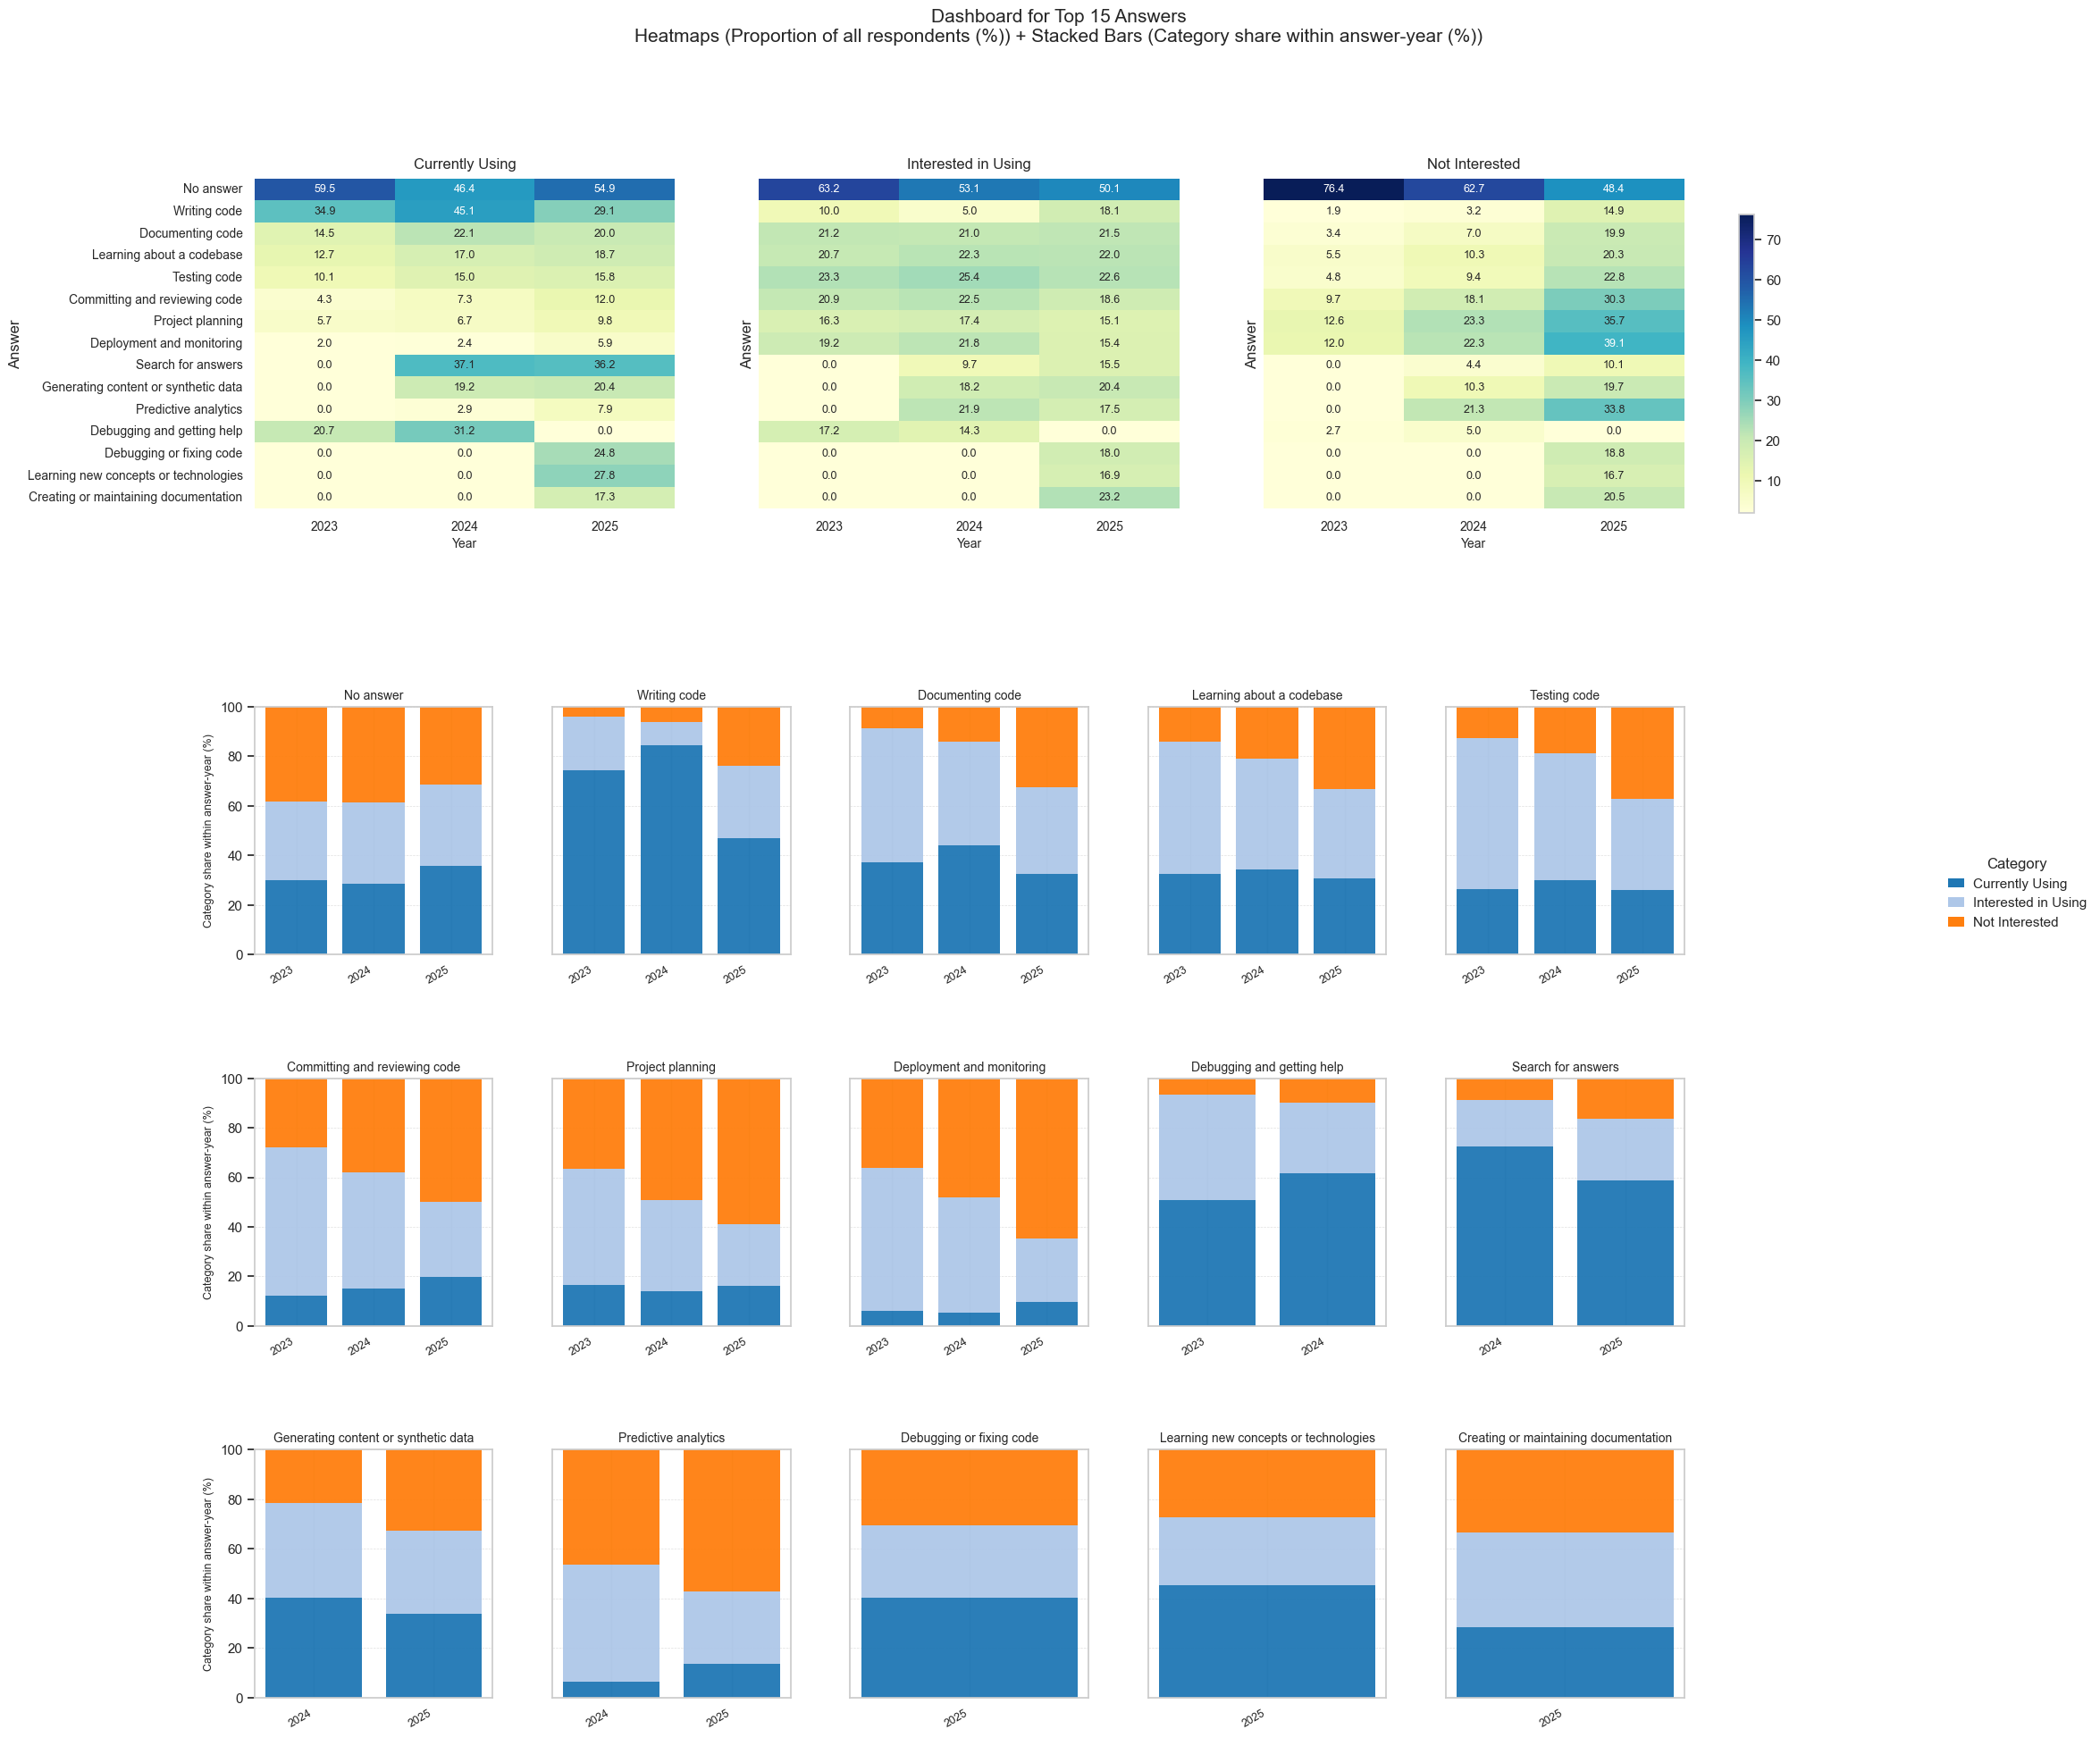

In [176]:
# ------------------------------------------------------------
# AITool Questions - plotting the results
# ------------------------------------------------------------

plot_combined_dashboard(
    trend_df=trend_df_AITool,                 # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts_AITool,           # per-year totals for normalization (relative='year')
    categories=categories_AITool,             # list of category labels (3 in your case)

    top_n=15,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars="answer",            # 100% stacks (category share)
    share_y=True,                      # all at 0–100
    annotate_bar_totals=False,         # write raw N above each bar
    show_bar_ylabel = False,            # show ylabel for each bar plot

    bar_cols=5,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.25,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

In [ ]:
# ------------------------------------------------------------
# AISelect Questions - preparations
# ------------------------------------------------------------

# 1) Prepare inputs
columns_to_analyze_AISelect = [
    "AISelect"
]

# Optional: map raw column names to category labels.
# If omitted, the raw column names will appear in the plots.
category_map_AISelect = {
    "AISelect": "Do you currently use AI tools in your development process?"
}

# 2) Combine surveys
long_df = prepare_long_format(survey_dict, columns_to_analyze_AISelect)

# 3) Build Answer × Year × Category counts (generic)
trend_df_AISelect, base_counts_AISelect, categories_AISelect = compute_trend_generic(
    long_df,
    columns_to_analyze_AISelect,
    category_map=category_map_AISelect,  # or None to use column names as categories
    answers=None,               # keep all answers; you could pass a list to restrict
    deduplicate_within_row=True
)

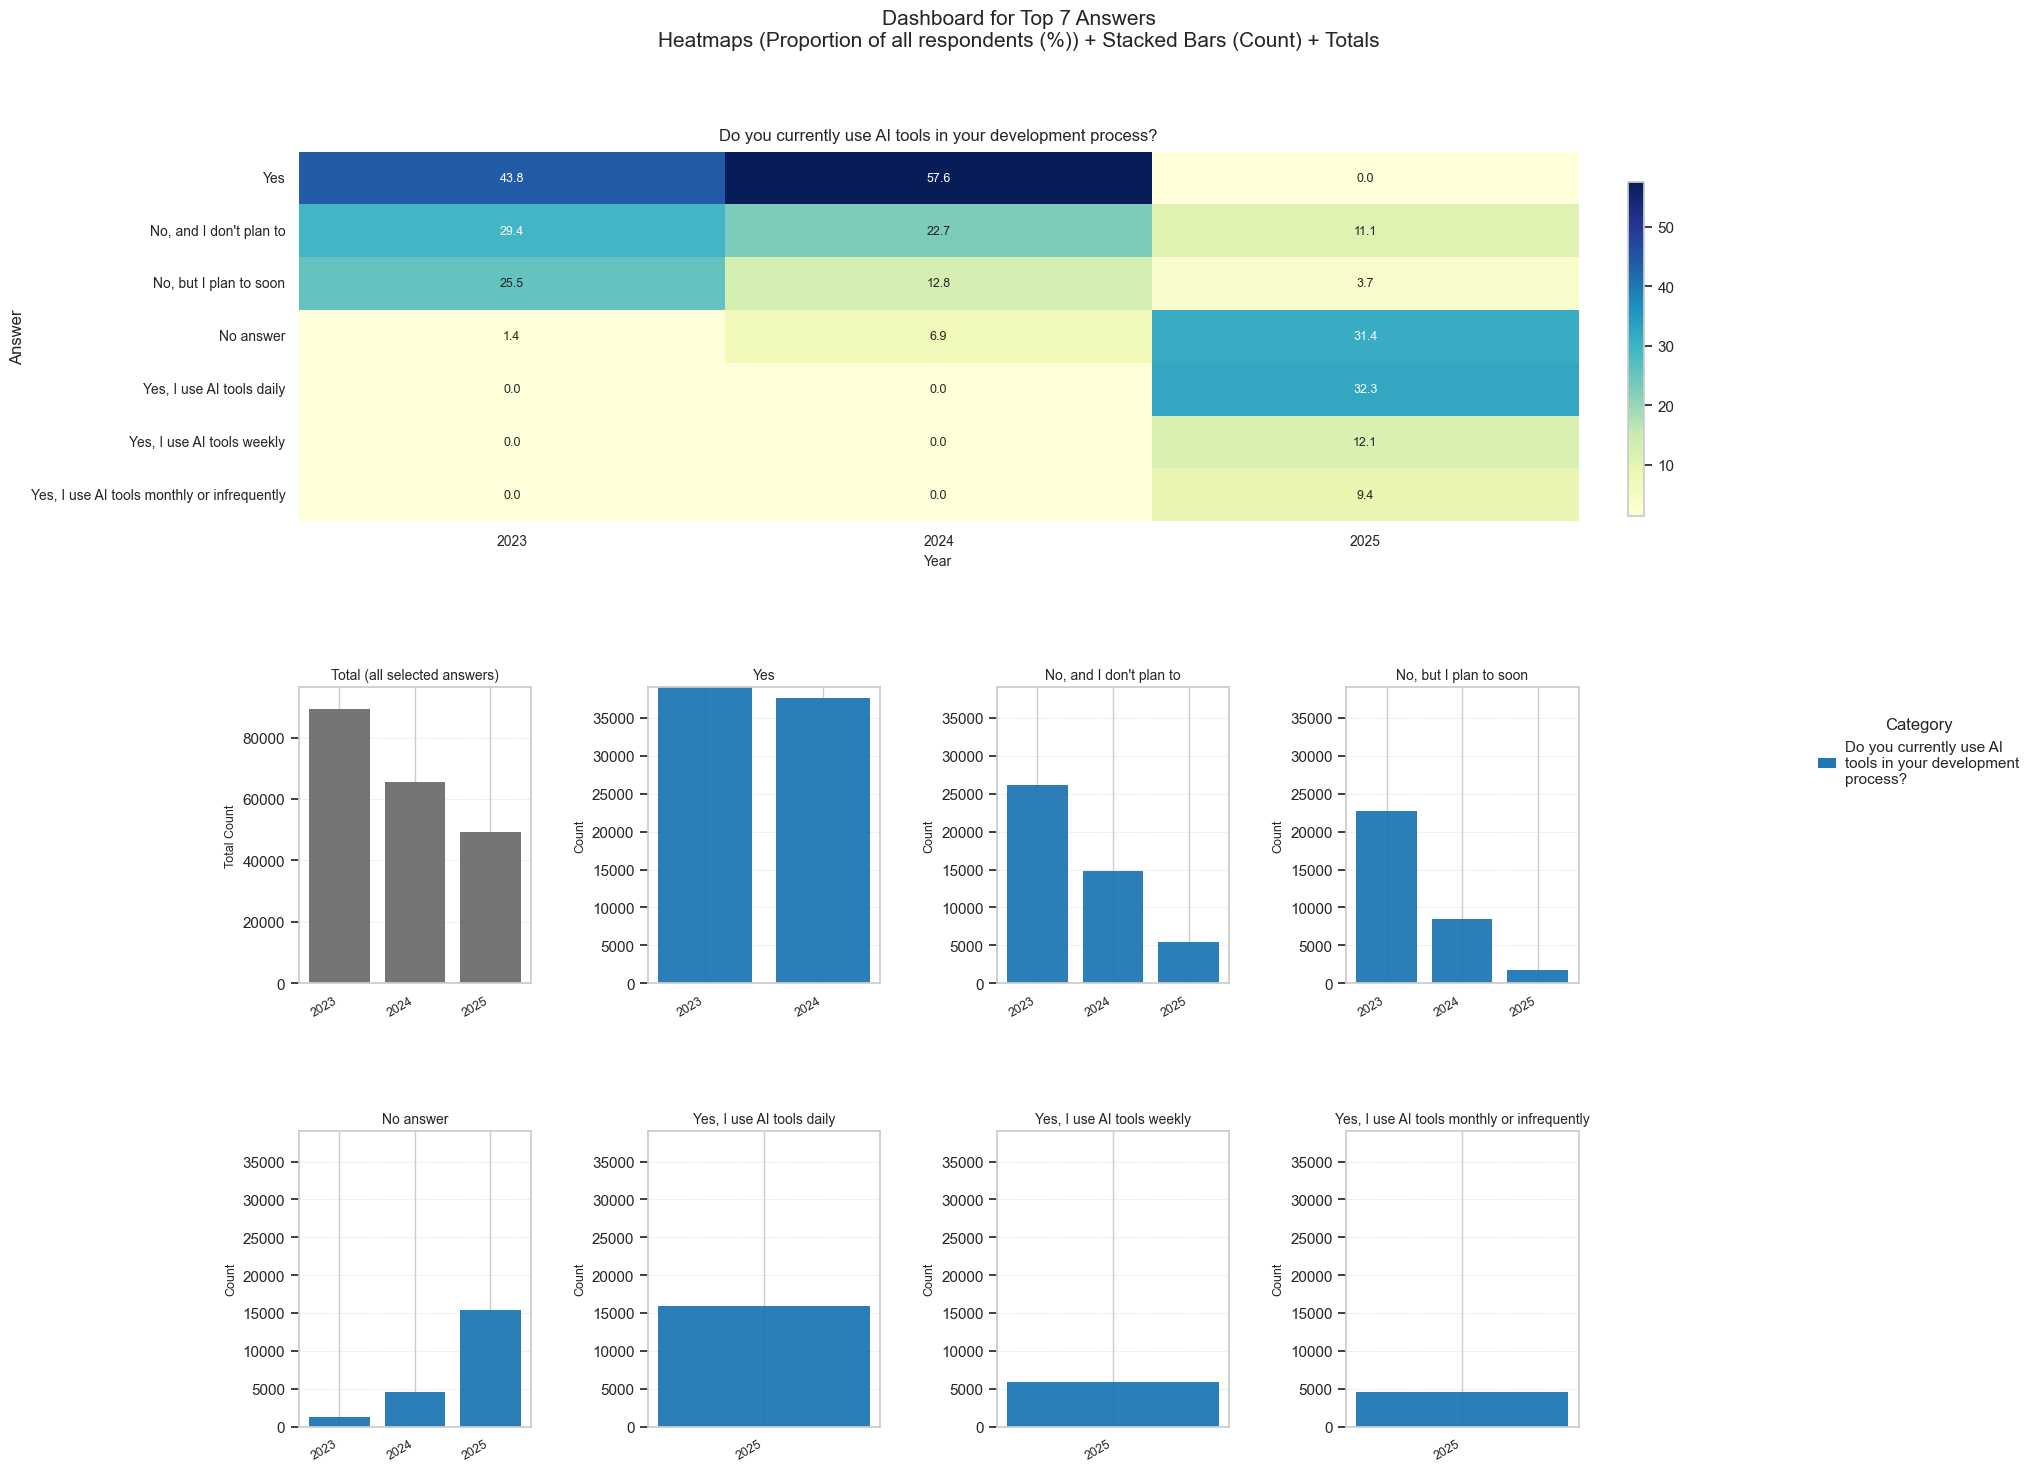

In [177]:
plot_combined_dashboard(
    trend_df=trend_df_AISelect,                 # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts_AISelect,           # per-year totals for normalization (relative='year')
    categories=categories_AISelect,             # list of category labels (3 in your case)

    top_n=7,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars=None,                # 100% stacks (category share)
    share_y=True,                      # all at 0–100
    annotate_bar_totals=False,          # write raw N above each bar
    show_bar_ylabel = True,            # show ylabel for each bar plot

    bar_cols=4,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.5,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

In order to compare better over the years, we will introduce a general "yes" answer for the survey of 2025.

In [145]:
YES_MERGE_MAP = {
    "Yes, I use AI tools daily": "Yes",
    "Yes, I use AI tools weekly": "Yes",
    "Yes, I use AI tools monthly or infrequently": "Yes"
    # add more mappings as needed…
}

trend_df_merged = (
    trend_df_AISelect
    .assign(Answer=lambda d: d["Answer"].astype(str).replace(YES_MERGE_MAP))
    .groupby(["Answer", "Year", "Category"], as_index=False, sort=False)["Count"]
    .sum()
)

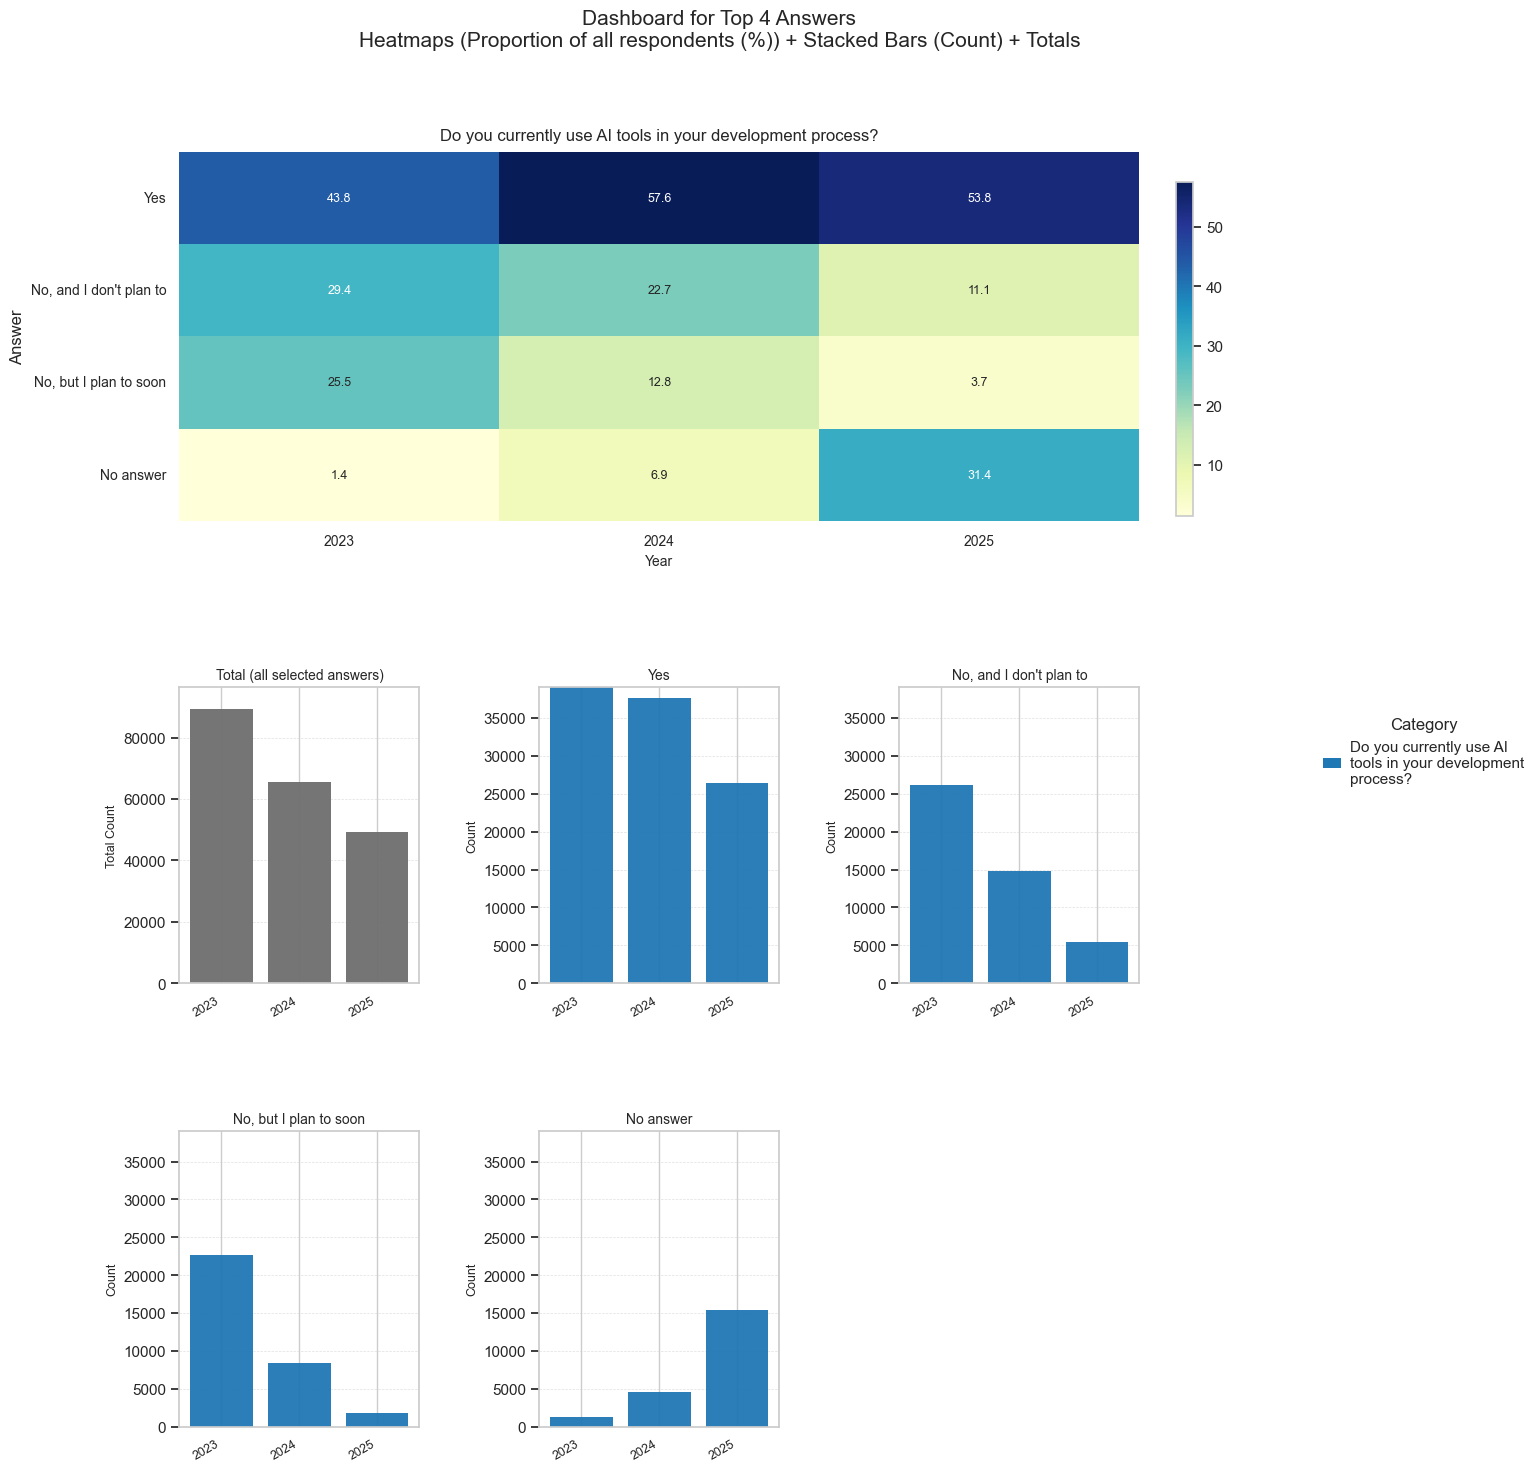

In [181]:
plot_combined_dashboard(
    trend_df=trend_df_merged,                   # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts_AISelect,           # per-year totals for normalization (relative='year')
    categories=categories_AISelect,             # list of category labels (3 in your case)

    top_n=4,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars=None,                # 100% stacks (category share)
    share_y=True,                      # all at 0–100
    annotate_bar_totals=False,          # write raw N above each bar
    show_bar_ylabel = True,            # show ylabel for each bar plot

    bar_cols=3,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.5,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

In [ ]:
# ------------------------------------------------------------
# AISent Questions - preparations
# ------------------------------------------------------------

# 1) Prepare inputs
columns_to_analyze_AISent = [
    "AISent"
]

# Optional: map raw column names to category labels.
# If omitted, the raw column names will appear in the plots.
category_map_AISent = {
    "AISent": "How favorable is your stance on using AI tools as part of your development workflow?"
}

# 2) Combine surveys
long_df = prepare_long_format(survey_dict, columns_to_analyze_AISent)

# 3) Build Answer × Year × Category counts (generic)
trend_df_AISent, base_counts_AISent, categories_AISent= compute_trend_generic(
    long_df,
    columns_to_analyze_AISent,
    category_map=category_map_AISent,  # or None to use column names as categories
    answers=None,               # keep all answers; you could pass a list to restrict
    deduplicate_within_row=True
)

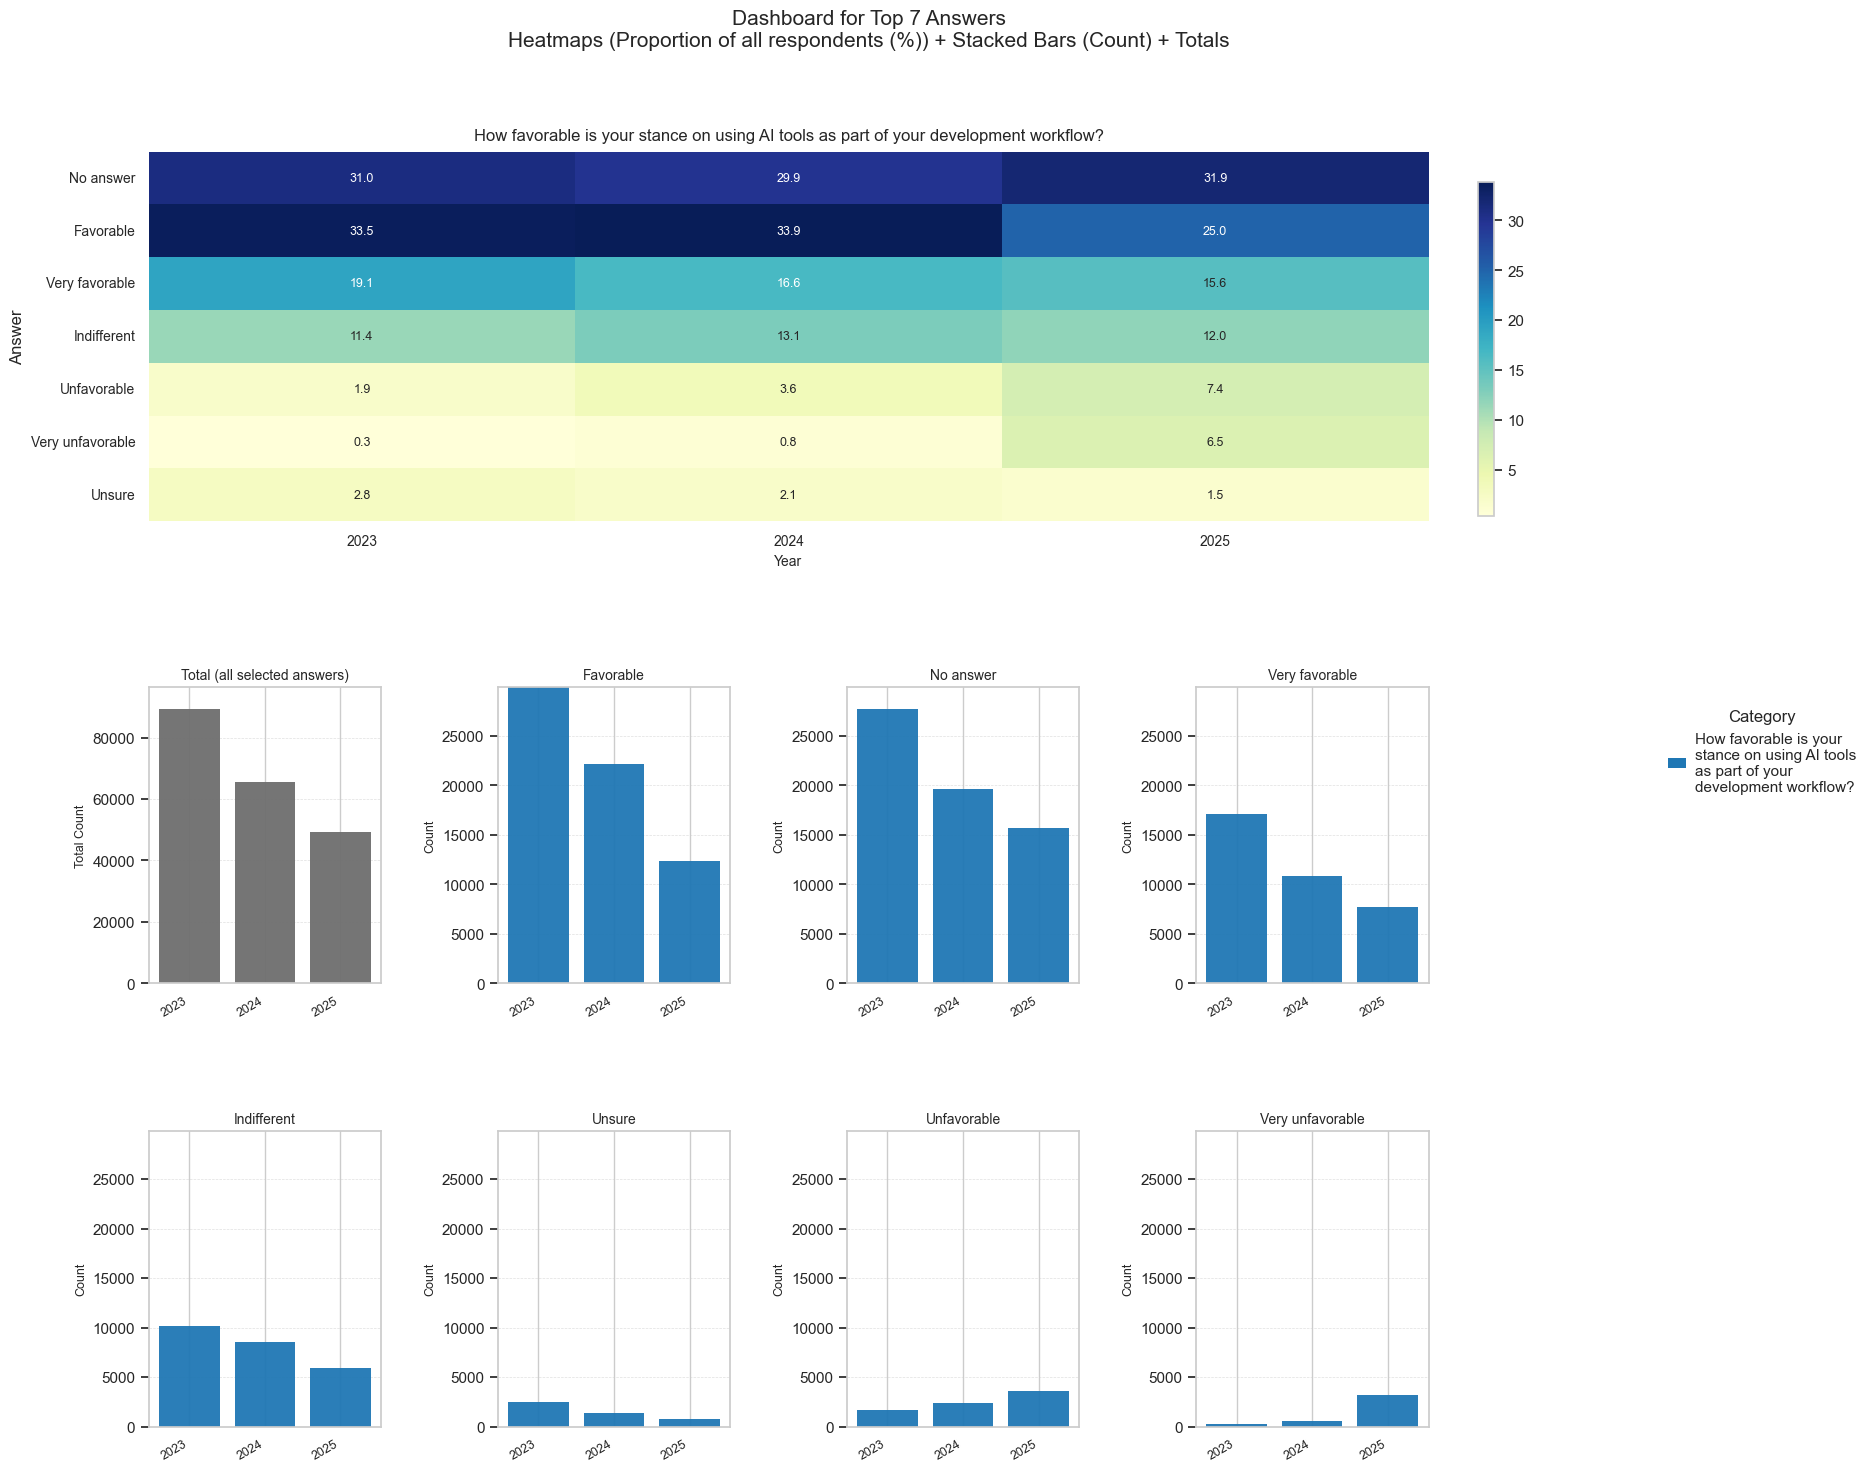

In [186]:
plot_combined_dashboard(
    trend_df=trend_df_AISent,                   # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts_AISent,           # per-year totals for normalization (relative='year')
    categories=categories_AISent,             # list of category labels (3 in your case)

    top_n=7,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars=None,                # 100% stacks (category share)
    share_y=True,                      # all at 0–100
    annotate_bar_totals=False,          # write raw N above each bar
    show_bar_ylabel = True,            # show ylabel for each bar plot

    bar_cols=4,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.5,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

In [ ]:
# ------------------------------------------------------------
# AISent Questions - preparations
# ------------------------------------------------------------

# 1) Prepare inputs
columns_to_analyze_AIAcc= [
    "AIAcc"
]

# Optional: map raw column names to category labels.
# If omitted, the raw column names will appear in the plots.
category_map_AIAcc = {
    "AIAcc": "How much do you trust the accuracy of the output from AI tools as part of your development workflow?"
}

# 2) Combine surveys
long_df = prepare_long_format(survey_dict, columns_to_analyze_AIAcc)

# 3) Build Answer × Year × Category counts (generic)
trend_df_AIAcc, base_counts_AIAcc, categories_AIAcc= compute_trend_generic(
    long_df,
    columns_to_analyze_AIAcc,
    category_map=category_map_AIAcc,  # or None to use column names as categories
    answers=None,               # keep all answers; you could pass a list to restrict
    deduplicate_within_row=True
)

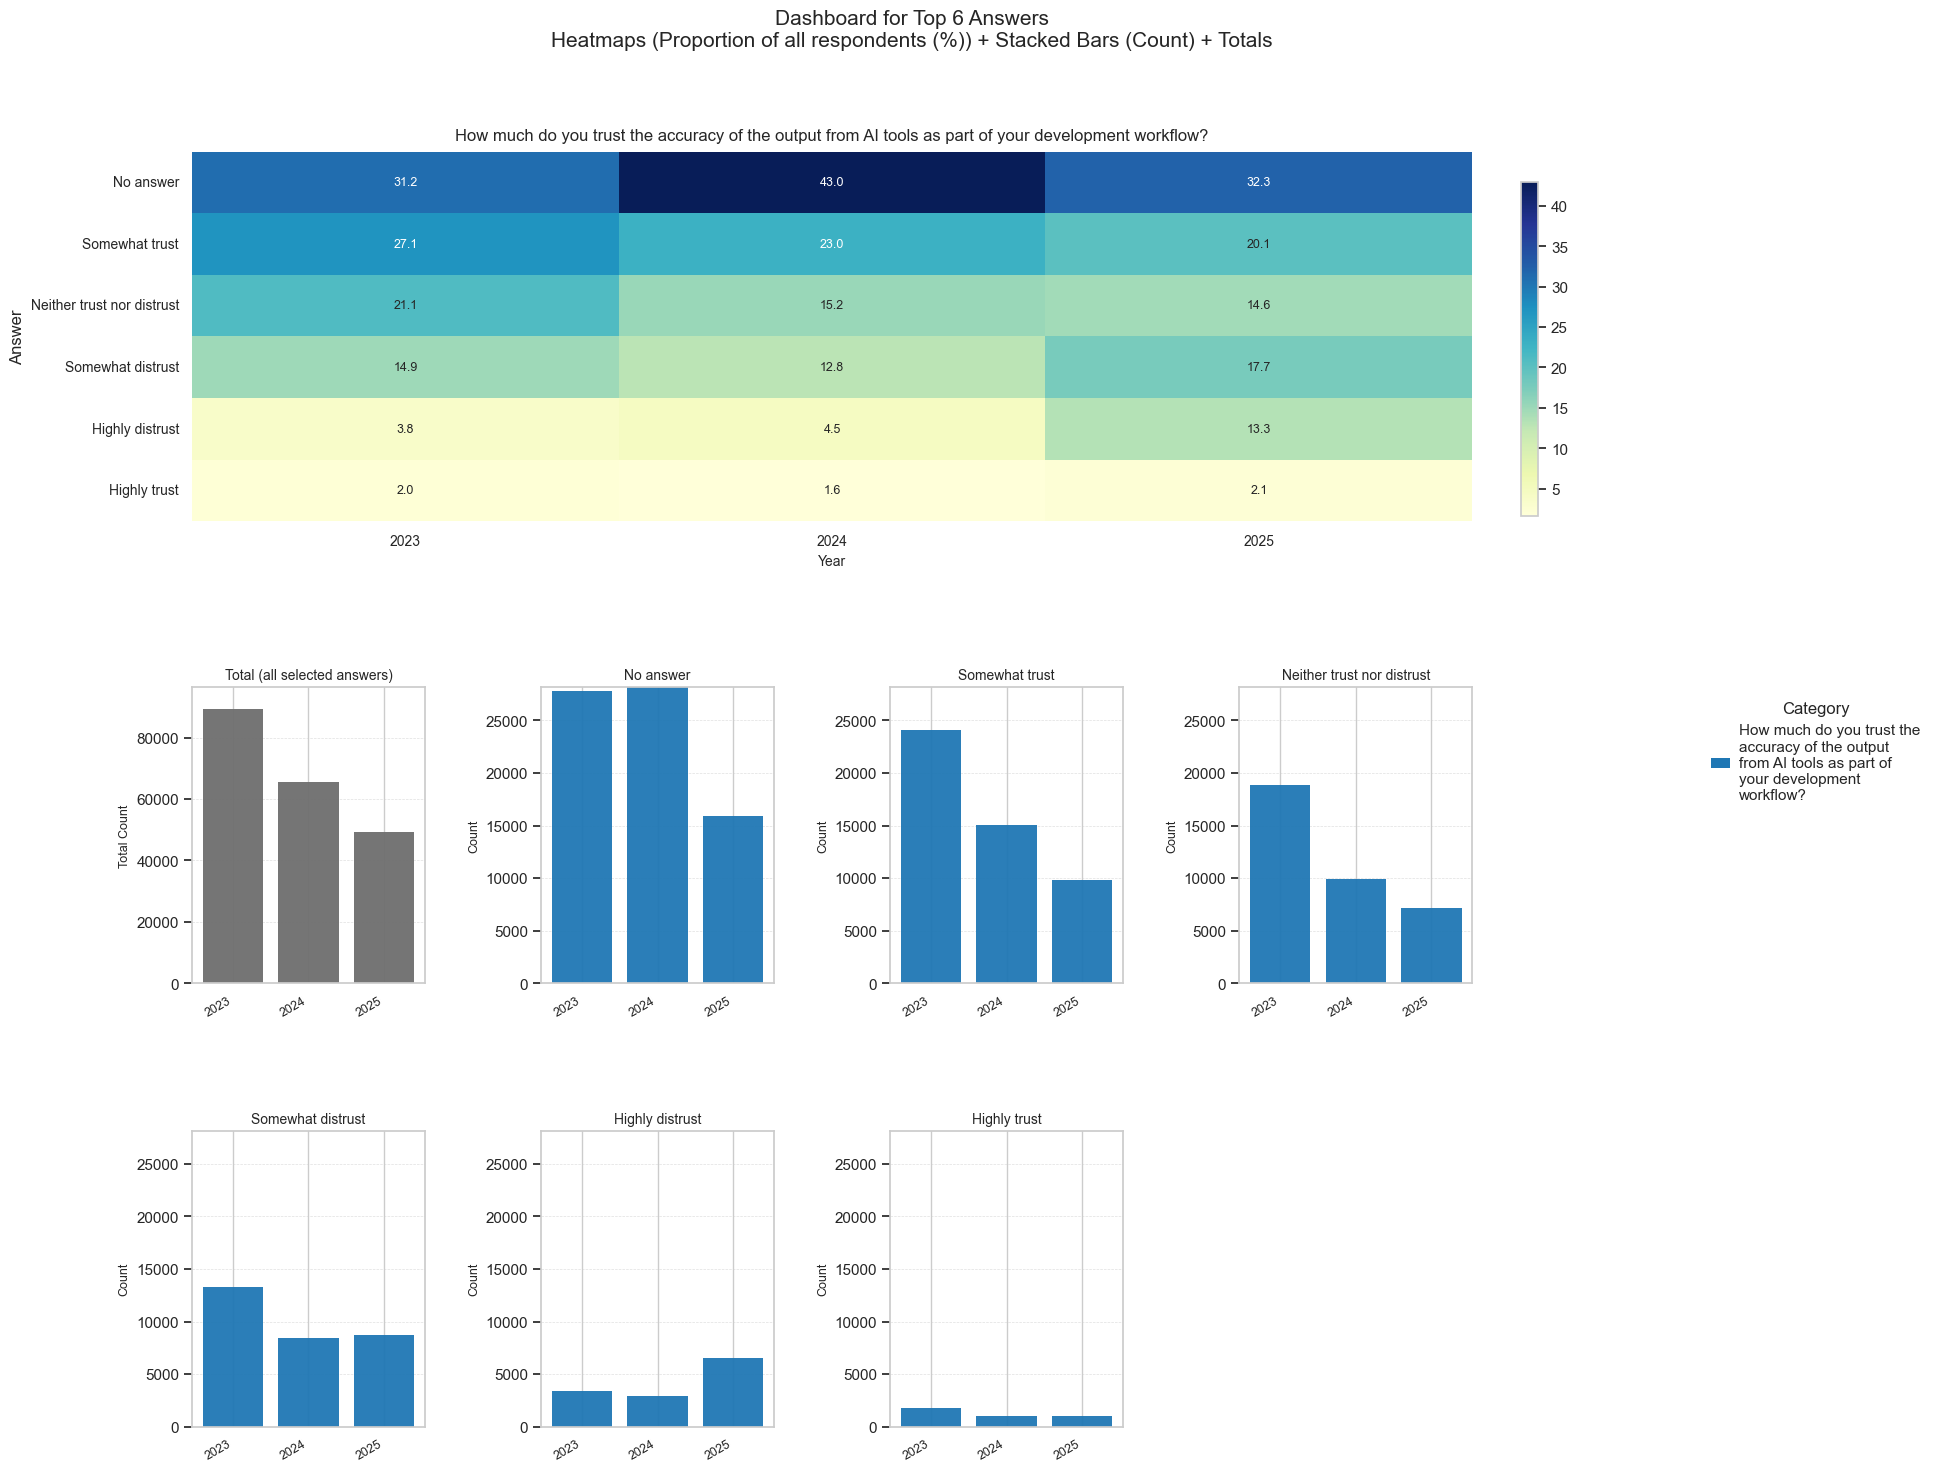

In [191]:
plot_combined_dashboard(
    trend_df=trend_df_AIAcc,                   # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts_AIAcc,           # per-year totals for normalization (relative='year')
    categories=categories_AIAcc,             # list of category labels (3 in your case)

    top_n=6,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars=None,                # 100% stacks (category share)
    share_y=True,                      # all at 0–100
    annotate_bar_totals=False,          # write raw N above each bar
    show_bar_ylabel = True,            # show ylabel for each bar plot

    bar_cols=4,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.5,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

I want to analyze the proportion of the "no answer" values with respect to the other answers of the surveys.

In [201]:
# Inputs
target_questions = (columns_to_analyze_AIAcc + columns_to_analyze_AISelect + columns_to_analyze_AISent + columns_to_analyze_AITool) # replace with your actual 4 question IDs

# AI-related questions from df_matches
ai_questions = df_matches.loc[df_matches["survey"].isin([f"survey_{y}" for y in ["2023","2024","2025"]]), "column_name"].tolist()

# Helper function to compute proportion of "no answer"
def compute_no_answer_prop(df):
    total = len(df)
    no_ans = (df["answer"].astype(str).str.lower() == "no answer").sum()
    return no_ans / total if total > 0 else None

rows = []

for year, survey_df in survey_dict.items():
    # Melt wide format to long format
    df_long = survey_df.melt(var_name="question", value_name="answer")
    
    # Group 0: Target questions
    target_df = df_long[df_long["question"].isin(target_questions)]
    target_prop = compute_no_answer_prop(target_df)

    # Group 1: All other questions
    other_df = df_long[~df_long["question"].isin(target_questions)]
    other_prop = compute_no_answer_prop(other_df)

    # Group 2: Other questions containing "AI"
    other_ai_df = other_df[other_df["question"].isin(ai_questions)]
    other_ai_prop = compute_no_answer_prop(other_ai_df)

    # Group 3: Other questions NOT containing "AI"
    other_non_ai_df = other_df[~other_df["question"].isin(ai_questions)]
    other_non_ai_prop = compute_no_answer_prop(other_non_ai_df)

    # Group 4: All questions
    all_prop = compute_no_answer_prop(df_long)

    rows.append({
        "Year": year,
        "Target Questions": target_prop,
        "All Other": other_prop,
        "Other AI": other_ai_prop,
        "Other Non-AI": other_non_ai_prop,
        "All": all_prop
    })

comparison_df = pd.DataFrame(rows)
print(comparison_df)

   Year  Target Questions  All Other  Other AI  Other Non-AI       All
0  2023          0.437756   0.323869  0.515322      0.318896  0.331908
1  2024          0.403347   0.383112  0.395807      0.382501  0.384167
2  2025          0.415019   0.522249  0.655430      0.500370  0.518442


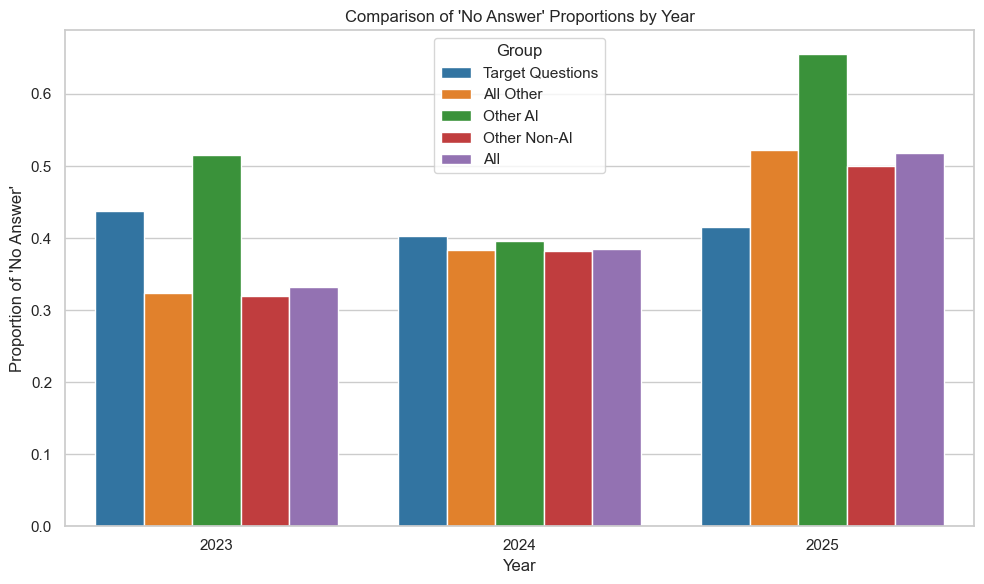

In [202]:
# Set Year as index for plotting
plot_df = comparison_df.set_index("Year")
plot_df_reset = plot_df.reset_index().melt(id_vars="Year", var_name="Group", value_name="Proportion")
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df_reset, x="Year", y="Proportion", hue="Group")
plt.title("Comparison of 'No Answer' Proportions by Year")
plt.ylabel("Proportion of 'No Answer'")
plt.tight_layout()
plt.show()